# Import data and libraries

* Can you describe the vibe of each Seattle neighborhood using listing descriptions?
* What are the busiest times of the year to visit Seattle? By how much do prices spike?


In [132]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')


%matplotlib inline

In [2]:
listings = pd.read_csv('airbnb data Seattle/listings.csv')
reviews = pd.read_csv('airbnb data Seattle/reviews.csv')
calendar = pd.read_csv('airbnb data Seattle/calendar.csv')

In [3]:
cal = calendar.copy()
lis = listings.copy()

# Understand the data and do some first checks

In [4]:
listings.head(3)

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  

[3 rows x 92 columns]

In [5]:
listings.last_scraped.max()

'2016-01-04'

In [6]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [7]:
lis.smart_location.value_counts()

Seattle, WA                  3810
West Seattle, WA                2
Seattle , WA                    2
Ballard, Seattle, WA            1
seattle, wa                     1
Phinney Ridge Seattle, WA       1
西雅图, WA                         1
Name: smart_location, dtype: int64

In [8]:
for col in (lis.columns[lis.nunique() == 2]):
    print(col, set(lis[col]))

host_acceptance_rate {nan, '100%', '0%'}
host_is_superhost {nan, 't', 'f'}
host_has_profile_pic {nan, 't', 'f'}
host_identity_verified {nan, 't', 'f'}
state {'wa', 'WA'}
is_location_exact {'t', 'f'}
instant_bookable {'t', 'f'}
require_guest_profile_picture {'t', 'f'}
require_guest_phone_verification {'t', 'f'}


In [9]:
lis.neighbourhood.value_counts()

Capitol Hill          351
Ballard               213
Belltown              204
Minor                 192
Queen Anne            187
                     ... 
South Park              2
Pike Market             2
Roxhill                 1
Fairmount Park          1
North College Park      1
Name: neighbourhood, Length: 81, dtype: int64

In [10]:
lis.neighbourhood_cleansed.value_counts()

Broadway             397
Belltown             234
Wallingford          167
Fremont              158
Minor                135
                    ... 
Arbor Heights          5
South Beacon Hill      4
Pinehurst              4
South Park             3
Roxhill                2
Name: neighbourhood_cleansed, Length: 87, dtype: int64

In [11]:
lis.neighbourhood_group_cleansed.value_counts()

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64

In [12]:
lis.state.value_counts()

WA    3817
wa       1
Name: state, dtype: int64

In [13]:
lis.host_location.value_counts()

Seattle, Washington, United States         3259
US                                          246
Spokane, Washington, United States           41
Kent, Washington, United States              34
Los Angeles, California, United States       13
                                           ... 
Seattle WA and Portland OR                    1
Santa Monica, California, United States       1
Snohomish, Washington, United States          1
Next door to cottage                          1
Austin, Texas, United States                  1
Name: host_location, Length: 120, dtype: int64

# Data Cleaning

* Check if target variable has missing values

In [14]:
lis.price.isna().any()

False

## Convert columns to float or date

### Convert price to float

In [15]:
lis['price'] = listings.price.str.replace('$','').str.replace(',','').astype(float)
lis['weekly_price'] = listings.weekly_price.str.replace('$','').str.replace(',','').astype(float)
lis['monthly_price'] = listings.monthly_price.str.replace('$','').str.replace(',','').astype(float)
lis['cleaning_fee'] = listings.cleaning_fee.str.replace('$','').str.replace(',','').astype(float)
cal['price'] = calendar.price.str.replace('$','').str.replace(',','').astype(float)
lis['extra_people'] = listings.extra_people.str.replace('$','').str.replace(',','').astype(float)
lis['security_deposit'] = listings.extra_people.str.replace('$','').str.replace(',','').astype(float)


### Convert rates and % to float

In [16]:
lis['host_response_rate'] = listings.host_response_rate.str.replace('%','').astype(float)/100

### Convert str dates to time

In [17]:
cal['date'] = pd.to_datetime(calendar.date)
lis['host_since'] = pd.to_datetime(listings.host_since)
lis['last_review'] = pd.to_datetime(listings.last_review)

* Drop columns, which do not add any additional informations for regressions or analysis
** e.g. street, zip code, neighbourhood & neighbourhood cleansed as we can use neighbourhood_grouped_cleansed

In [18]:
def drop_columns(df, cols):
    for col in cols:
        if col in df.columns:
            df = df.drop(columns = col)
    return df


In [19]:
#only NA license
lis = drop_columns(lis, ['license'])

#all urls
url = lis.columns[lis.columns.str.contains('url')]
lis = drop_columns(lis, url)

#all available columns
avai = lis.columns[lis.columns.str.contains('availa')]
lis = drop_columns(lis, avai)

#host specific information, which is irrelevant
host = ['host_id', 'host_name','host_acceptance_rate', 'host_location', 'host_neighbourhood', 'host_verifications']
lis = drop_columns(lis, host)

#location information, which is covered by neighbourhood_grouped_cleansed
loc_info = ['neighbourhood', 'neighbourhood_cleansed', 'street', 'zipcode', 'state', 'city']
lis = drop_columns(lis, loc_info)

#weekly and monthly price as I am only interested in price and it is slghtly redundant
lis = drop_columns(lis, ['weekly_price', 'monthly_price'])

#technical info
lis = drop_columns(lis,  ['calendar_updated', 'first_review'])

lis = drop_columns(lis,  ['smart_location', 'experiences_offered', 'name'])


#drop dates for prediction. Does not work for linaer regression or logistoc regression
lis = drop_columns(lis,  ['last_review', 'host_since'])

* Convert all true false columns into binary columns

In [20]:
def convert_True_False(df):
    true_false_cols = []
    for col in df.columns[df.dtypes=='object']:
        if all(elem in df[col].unique() for elem in ['f', 't']):
            df[col] = df[col].map({'f': False, 't':True})
            df[col] = df[col].astype('bool')
            true_false_cols.append(col)
    return df, true_false_cols

In [21]:
lis, true_false_cols = convert_True_False(lis)

Drop all columns, which contain only 1 unique value. They do not add any additional information and drop columns, which have more than 30% of the data row unique values --> No time to do any grouping or classification

In [22]:
def drop_col_no_info(df):
    """
    Drop columns, which contain only one unique value
    Drop Ids
    """
    df = df.drop(columns = lis.columns[lis.nunique()==1])
    df = df.drop(columns = lis.columns[lis.nunique()==len(lis)])
    df = df.drop(columns = lis.columns[(lis.dtypes=='object') & ((lis.nunique()/len(lis)) > 0.3)])
    return df

In [23]:
lis = drop_col_no_info(lis)

In [24]:
lis[lis.columns[lis.dtypes=='object']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   host_response_time            3295 non-null   object
 1   neighbourhood_group_cleansed  3818 non-null   object
 2   property_type                 3817 non-null   object
 3   room_type                     3818 non-null   object
 4   bed_type                      3818 non-null   object
 5   cancellation_policy           3818 non-null   object
dtypes: object(6)
memory usage: 179.1+ KB


In [25]:
for col in lis.columns[lis.dtypes=='object']:
    print(col, ': \n', lis[col].value_counts())

host_response_time : 
 within an hour        1692
within a few hours     968
within a day           597
a few days or more      38
Name: host_response_time, dtype: int64
neighbourhood_group_cleansed : 
 Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Seward Park             44
Interbay                11
Name: neighbourhood_group_cleansed, dtype: int64
property_type : 
 House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent   

In [26]:
lis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3295 non-null   object 
 1   host_response_rate                3295 non-null   float64
 2   host_is_superhost                 3818 non-null   bool   
 3   host_listings_count               3816 non-null   float64
 4   host_total_listings_count         3816 non-null   float64
 5   host_has_profile_pic              3818 non-null   bool   
 6   host_identity_verified            3818 non-null   bool   
 7   neighbourhood_group_cleansed      3818 non-null   object 
 8   is_location_exact                 3818 non-null   bool   
 9   property_type                     3817 non-null   object 
 10  room_type                         3818 non-null   object 
 11  accommodates                      3818 non-null   int64  
 12  bathro

## Clean numerical columns

In [27]:
def clean_numerical_col(df, exclude):
    num_col = df.drop(columns = exclude).select_dtypes(include = ['float', 'int']).columns
    print(num_col)
    fill_mean = lambda col: col.fillna(col.mean())
    df[num_col] = df[num_col].apply(fill_mean, axis = 0)
    return df

In [28]:
lis = clean_numerical_col(lis, true_false_cols + ['price'])
lis.info()

Index(['host_response_rate', 'host_listings_count',
       'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'security_deposit', 'cleaning_fee', 'extra_people',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3295 non-null   object 
 1   host_response_rate                3818 non-null   float64
 2   host_is_superhost                 3818 non-null   bool   
 3   host_listings_count               3818 non-null   float64
 4   host_total_listings_count         3818 non-null   float64
 

In [29]:
print(true_false_cols)
lis.info()
#X = pd.get_dummies(X, columns = X.columns[X.dtypes == "object"], drop_first=True , dummy_na=False)

['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3295 non-null   object 
 1   host_response_rate                3818 non-null   float64
 2   host_is_superhost                 3818 non-null   bool   
 3   host_listings_count               3818 non-null   float64
 4   host_total_listings_count         3818 non-null   float64
 5   host_has_profile_pic              3818 non-null   bool   
 6   host_identity_verified            3818 non-null   bool   
 7   neighbourhood_group_cleansed      3818 non-null   object 
 8   is_location_exact                 3818 non-null   bool   
 9   property_type

# Gather some visual information

## histogram of prices

**Findings**  


Air BnB prices in Seattle vary between 20 Dollar and 1000 Dollar per night!  

Most common are prices around 100$ per night

min  20.0 max  1000.0
median 100.0


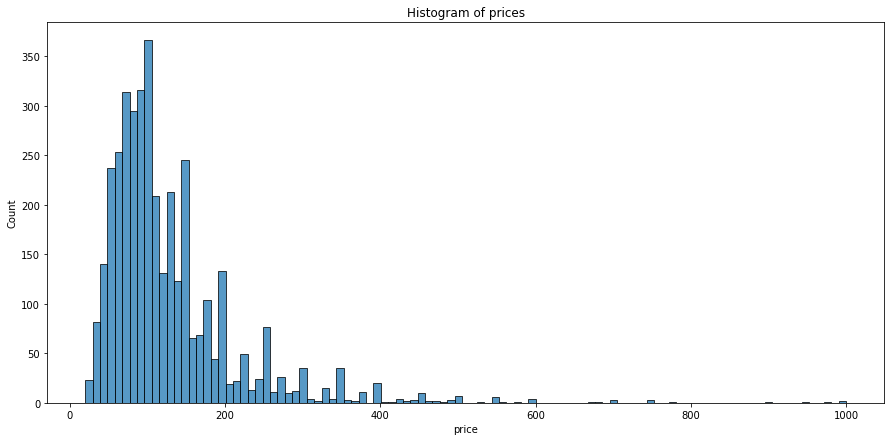

In [30]:
fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
sns.histplot(x="price", data = lis)
plt.title('Histogram of prices')
plt.savefig('pictures/Price histogram')
print('min ',lis.price.min(),'max ',lis.price.max())
print('median', lis.price.median())

## Boxplot of prices

We have many outliers in the data. I think it will be very difficult to catch them properly. Hence I will try to remove them

-37.5 262.5
3818
3572
% of dropped rows due to outlier cleaning: 0.0644316396018858


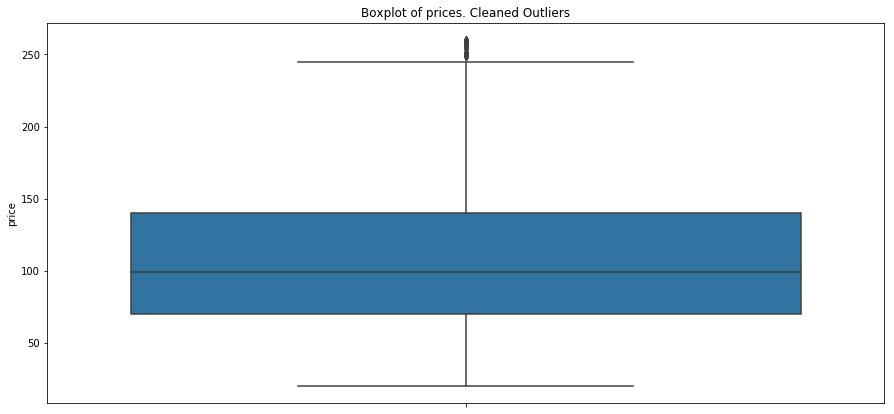

In [31]:
Q1 = lis['price'].quantile(0.25)
Q3 = lis['price'].quantile(0.75)
IQR = Q3-Q1
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR
print(Lower_Whisker, Upper_Whisker)

fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
sns.boxplot(y="price", data=lis[lis['price']< Upper_Whisker])#
plt.xticks(rotation=45)
plt.title('Boxplot of prices. Cleaned Outliers')
plt.savefig('pictures/Price boxplot')

lis_drop_outlier = lis[lis['price']< Upper_Whisker]
print(len(lis))
print(len(lis_drop_outlier))
print('% of dropped rows due to outlier cleaning:', 1 -(len(lis_drop_outlier)/len(lis)))

## Boxplotof price per categorical variable

**Findings**
I tried to find features, which can describe different prices the best. First I looked at categorical features, which are not represented as numbers. These in clude the neighbourhood, property_type, room_type & bed_type
* **property type** In general the property has a price tendencies, but almost all property types have very expensive exceptions. Hence searching for a specific type is not a a price guaranty
    * As expected dorms are by far the cheapest 
    * Lofts, Townhouses, Boats and Condominium are the most expensive
    * Cheap, but more private are campers, bungalows, cabins and tents
    * apertments and houses range in the middle, but they have some very expensive exceptions
    
* **neighbourhood** 
    * Downtown, Magnolia and Queen Hill are most expensive
    * Beacon, University District and Lake City are the cheapest
    
* **room type** 
    * As expected entire home > private room > shared room 
    


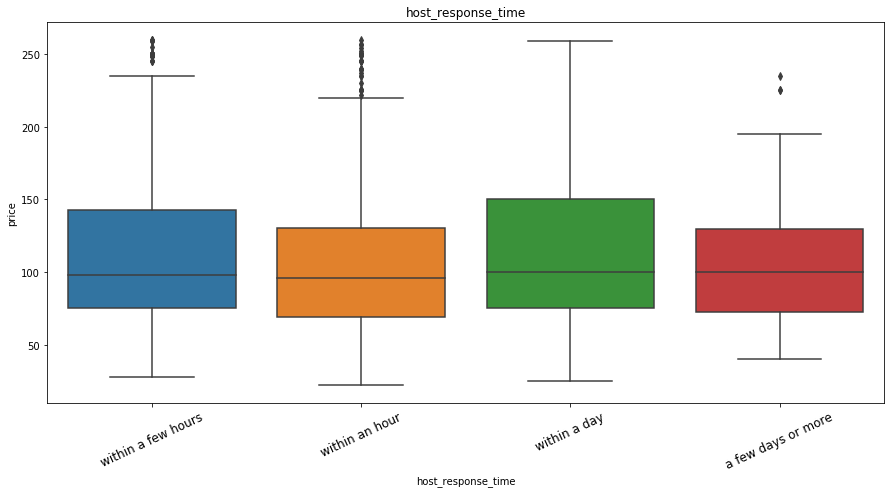

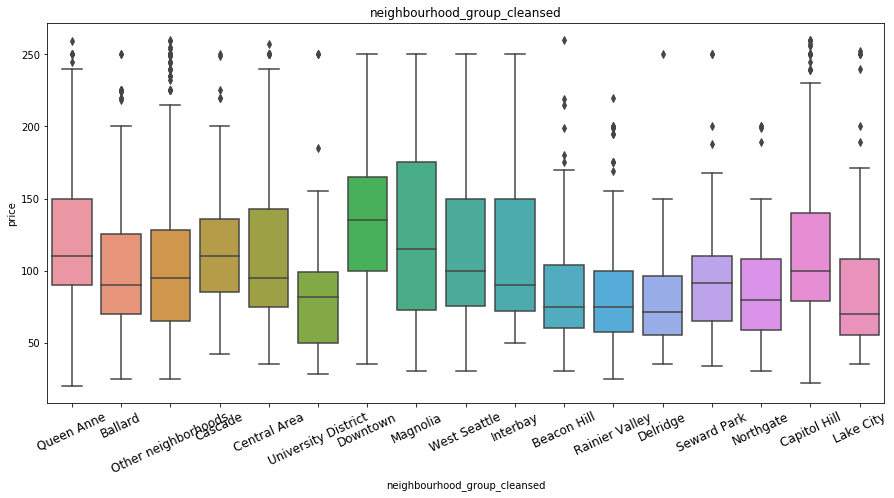

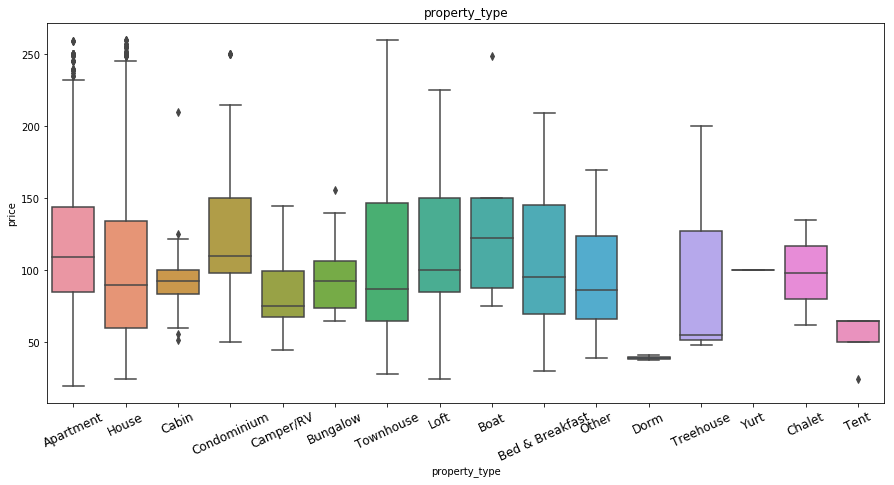

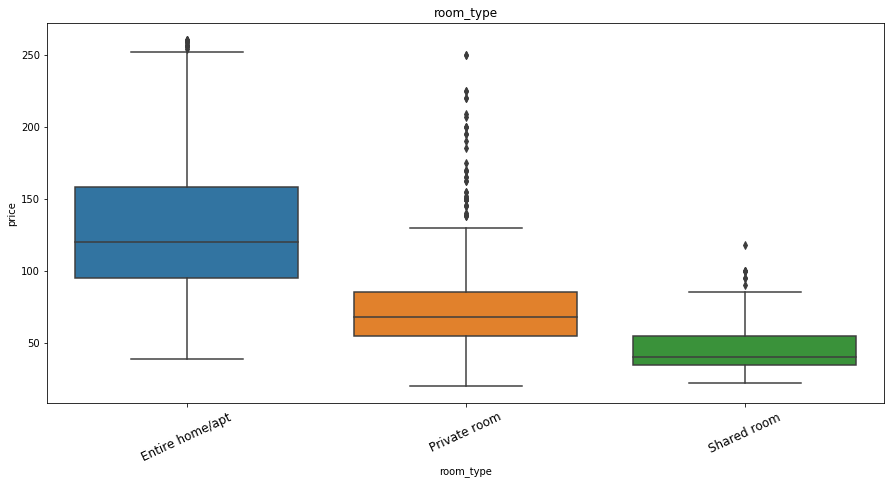

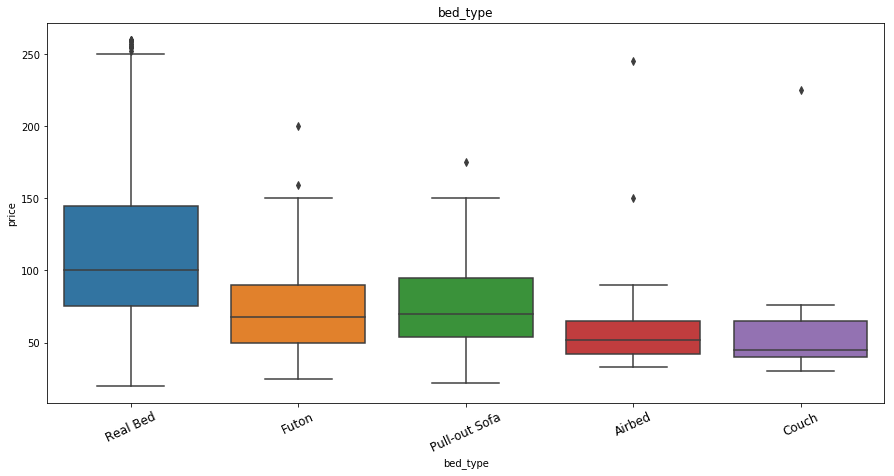

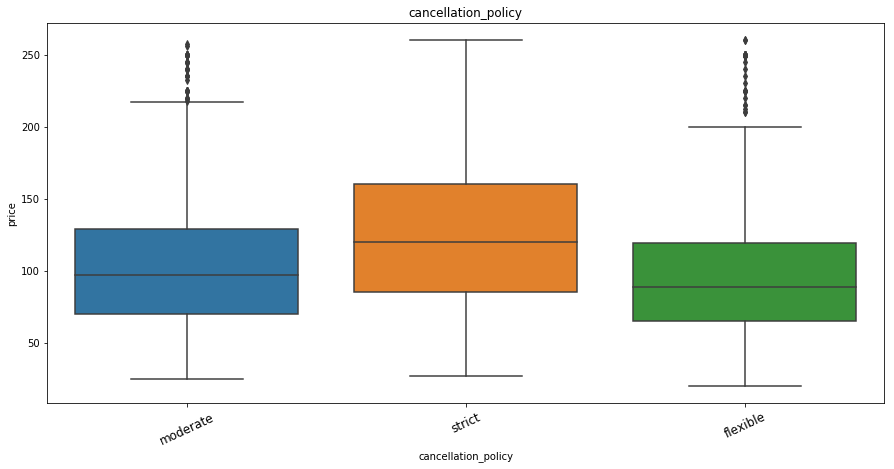

In [32]:
for col in lis.columns[lis.dtypes == "object"]:
    fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
    sns.boxplot(x=col, y="price", data=lis_drop_outlier)
    plt.xticks(rotation=25, size=12)
    plt.title(col)
    plt.savefig('pictures/boxplot_' + col)

In [33]:
lis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3295 non-null   object 
 1   host_response_rate                3818 non-null   float64
 2   host_is_superhost                 3818 non-null   bool   
 3   host_listings_count               3818 non-null   float64
 4   host_total_listings_count         3818 non-null   float64
 5   host_has_profile_pic              3818 non-null   bool   
 6   host_identity_verified            3818 non-null   bool   
 7   neighbourhood_group_cleansed      3818 non-null   object 
 8   is_location_exact                 3818 non-null   bool   
 9   property_type                     3817 non-null   object 
 10  room_type                         3818 non-null   object 
 11  accommodates                      3818 non-null   int64  
 12  bathro

## Boxplots and histograms of price per binary variable

**Findings**
Some informations in the dataset are binary. Is there a binary feature, which splits expensive vs. cheap apartmets? Unfrortunately teh answer is no
* **host is superhost** Apartments from superhosts are not generally more expensive. Both types have a median price of around 100 Dollar. But superhost listings have more expensive outliers than non-superhost listings. This could be due to more modern, luxurious apartments or due to better areas  
    
* **require guest profile picture and phone verification** Interestingly listings, which require a profile picture or a phone verification tend to be more expensive. It makes sens that landlords want to have more safety for more expensive accomodations and furniture

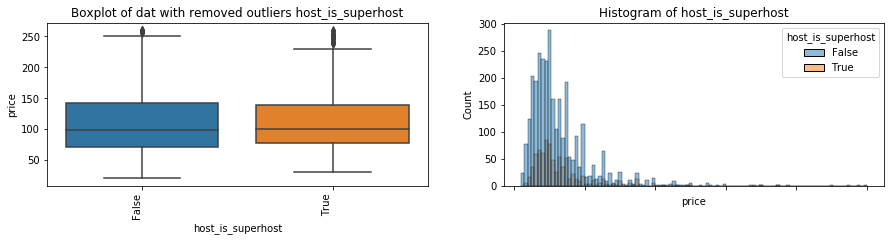

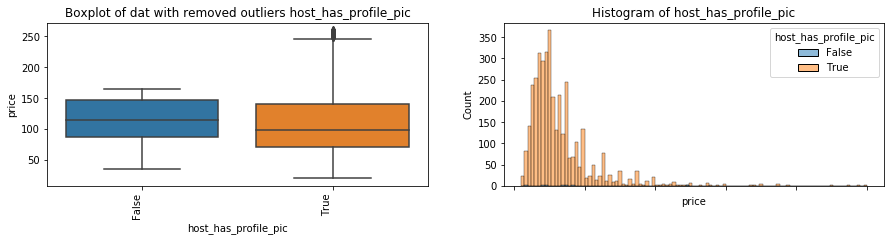

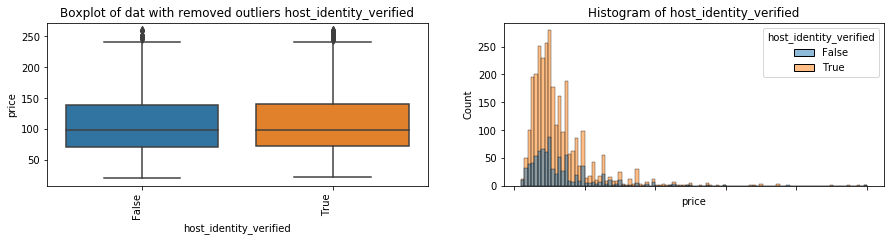

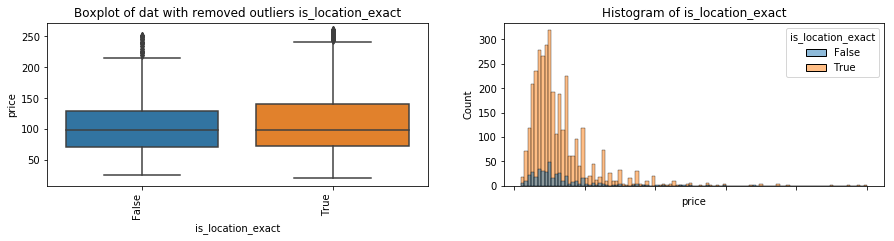

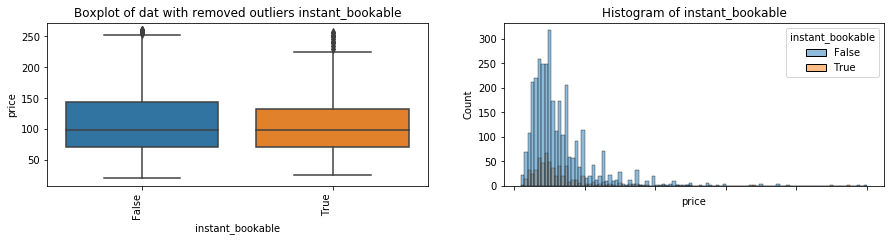

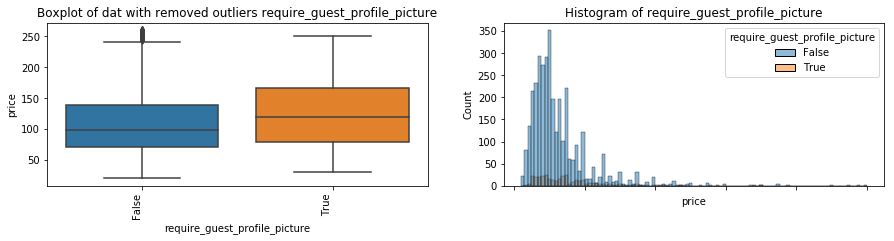

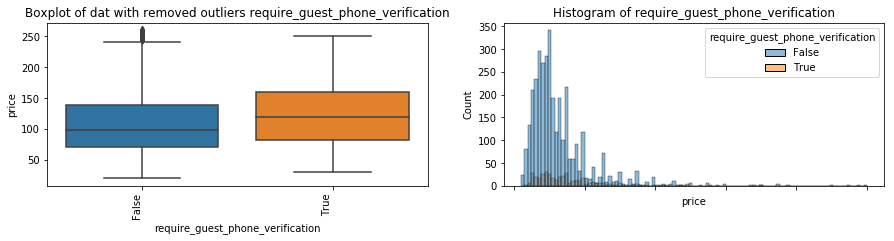

In [34]:
for col in true_false_cols:
    fig, ax = plt.subplots(1,2, figsize = (15,3))
    g1 = sns.boxplot(ax = ax[0], x=col, y="price", data=lis_drop_outlier)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90, horizontalalignment='right')
    g1.set_title('Boxplot of dat with removed outliers ' + col)
    g2 = sns.histplot(ax = ax[1], x="price", data = lis, hue = col)
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90, horizontalalignment='right')
    g2.set_title('Histogram of ' + col) 

## Correlation of numerical variables

**Some data correlates and can be dropped**

* From all scores columns, keep only the ones, which have correl < 0.5 to the overall review_scores_rating --> Drop all except review_scores_rating and review_scores_location

In [35]:
corr = lis[lis.columns[lis.columns.str.contains('scores')]].corr()

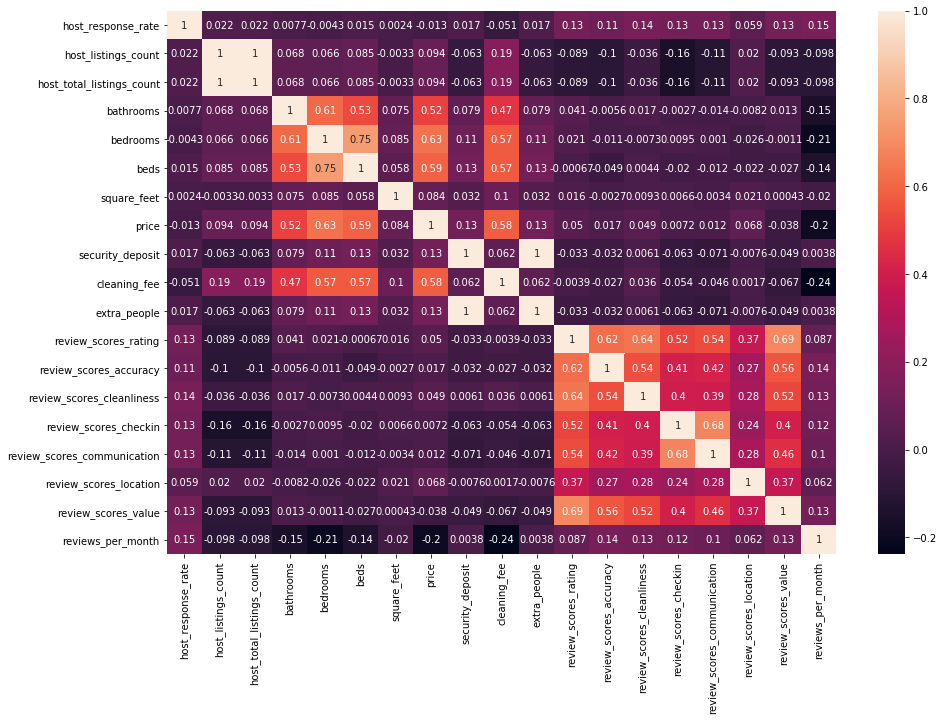

In [36]:
#col = list(lis.columns[lis.columns.str.contains('scores')])
#col.extend(['price'])
fig = plt.subplots(1,1, figsize = (15,10))
col = lis.select_dtypes(include = ['float', 'int']).columns
sns.heatmap(data = lis[col].corr(), annot = True);

Drop correlating columns with no additional information

In [37]:
corr_col = corr.columns[corr.loc['review_scores_rating']>0.5].drop('review_scores_rating')
print(corr_col)
lis = drop_columns(lis, corr_col)
lis = drop_columns(lis, ['security_deposit','beds', 'host_total_listings_count'])

Index(['review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_value'],
      dtype='object')


## Scatterplots between numerical variables and price

**Findings**
I was hoping to find a variable, which has a linear or even exponential relationship with the price. But there are too many other factors, which might play a role. The is one excitin outcome though: The rating does not correlate with the price. What does that mean? It means that you can find a real jewel with amazing rating but an affordable price.
* **host listing counts**. There seems to be a min. boundary relation between host listings counts and price. The more listings a host has, the higher is the cheapest available price
* **bedrooms**. Similar behaviour as above
* **people** Similar behaviour as above
* **cleaning fee** See above. Makes sense - furniture, which requires special care or bigger places have higher cleaning fees and are in general more expensive
* **review score rating** great news for all customers! A higher review score does not mean a higher price. There seems to be absolutely no correlation and you can probably find hidden gems there!

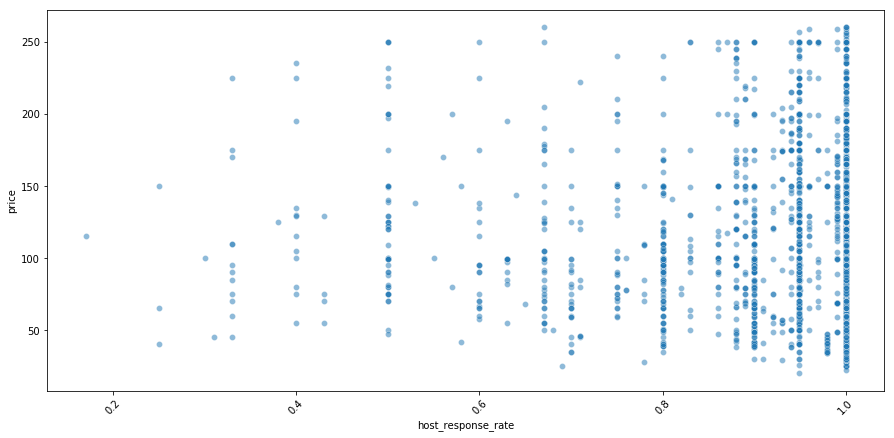

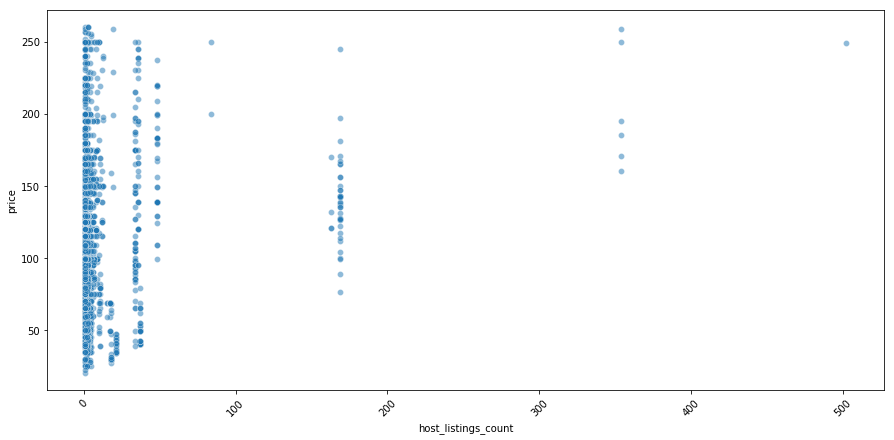

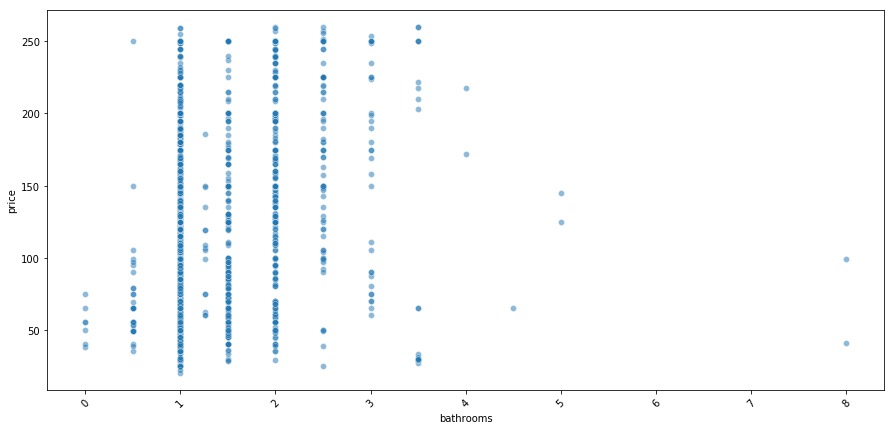

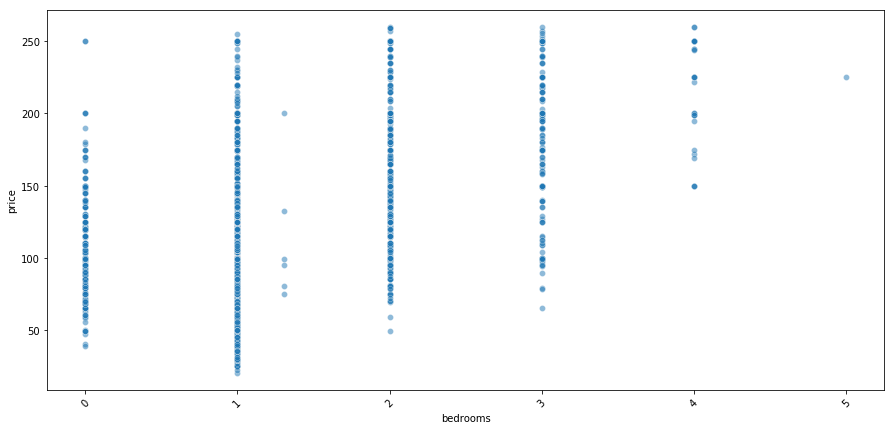

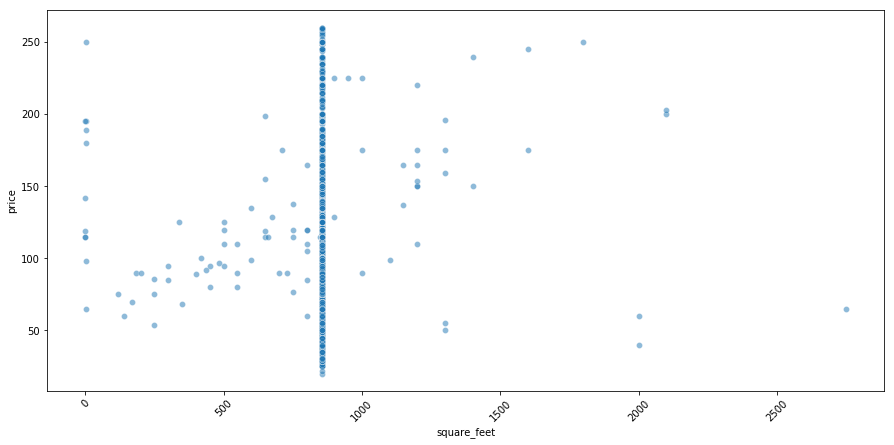

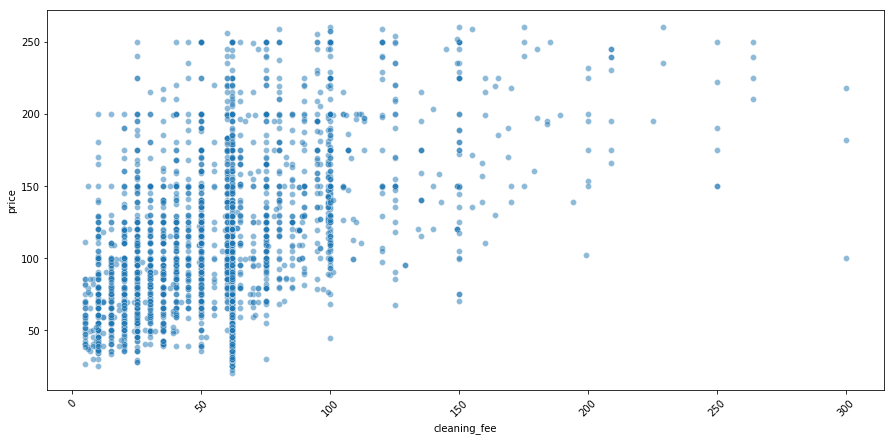

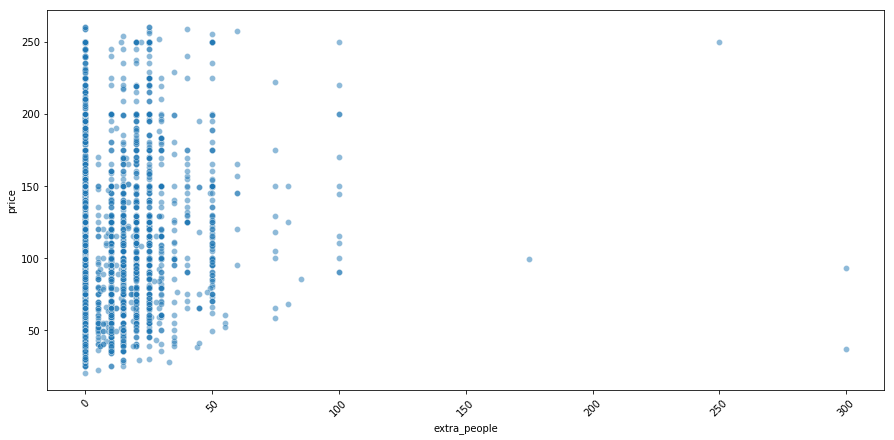

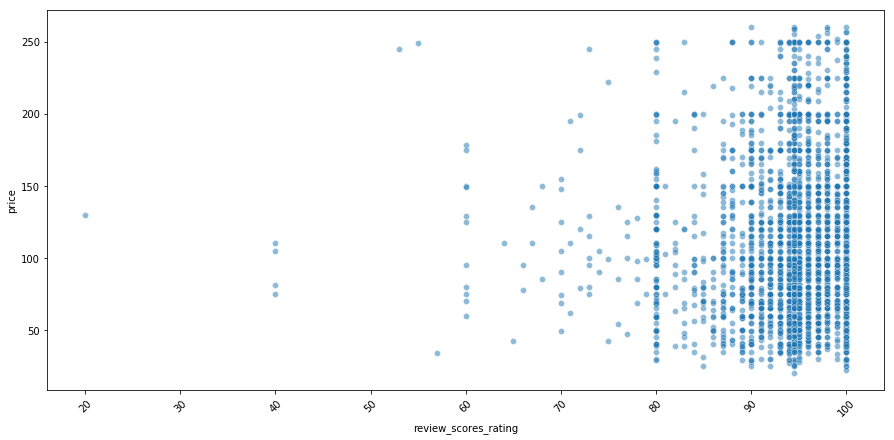

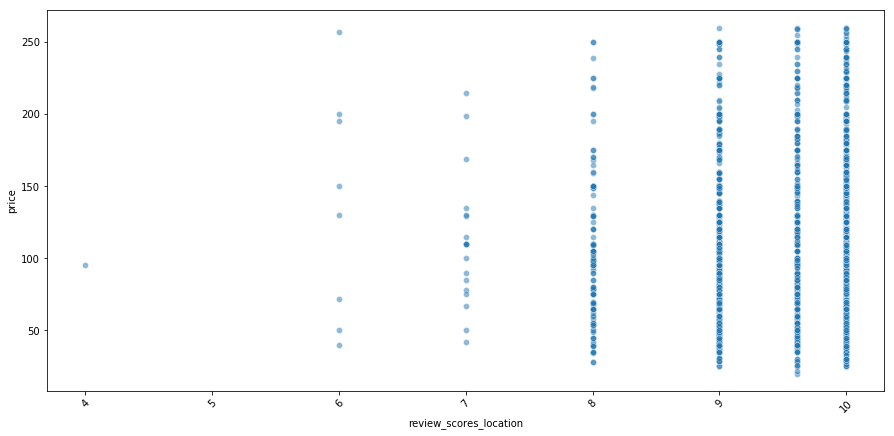

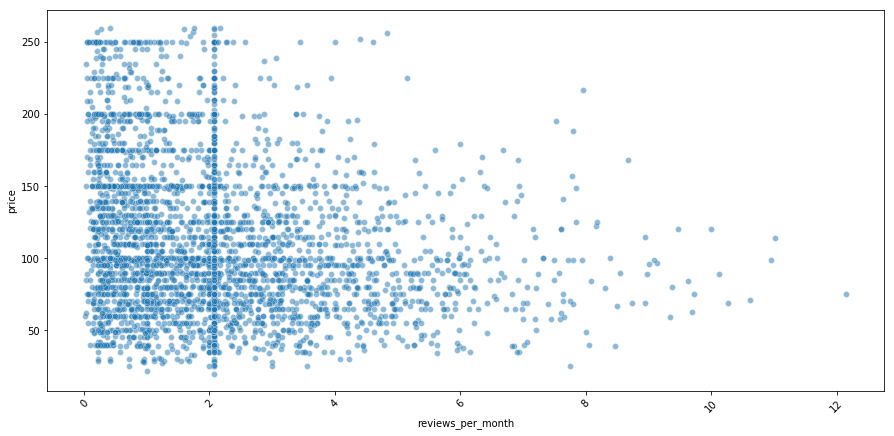

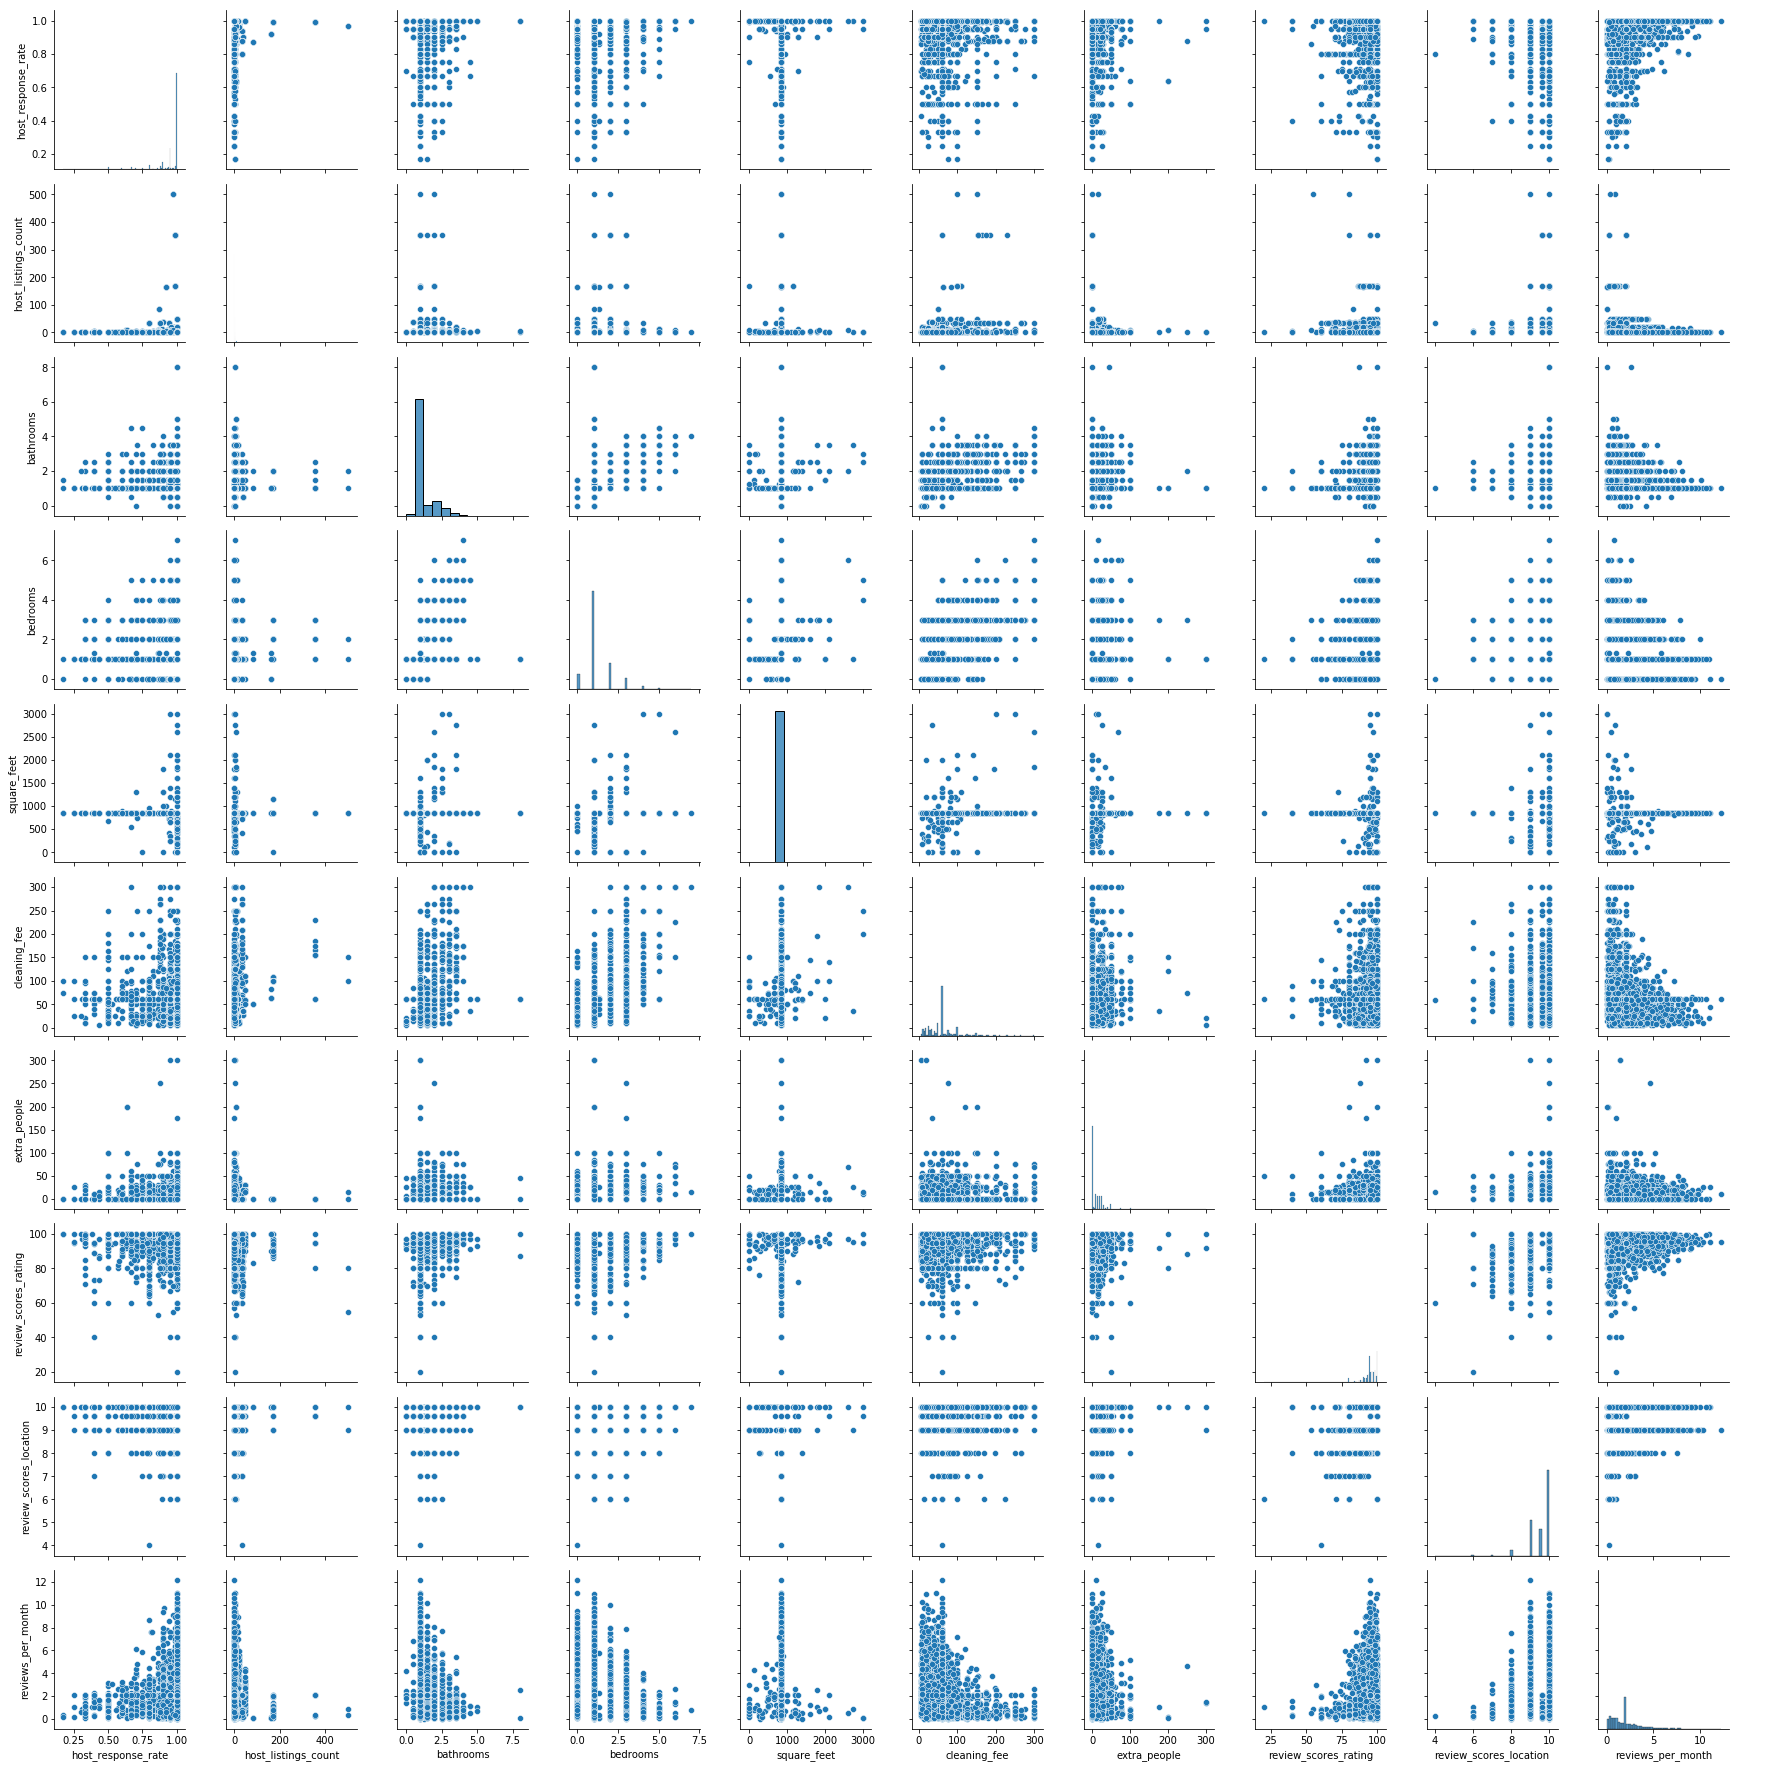

In [38]:
num_col = lis.drop(columns = true_false_cols + ['price']).select_dtypes(include = ['float', 'int']).columns
for col in num_col:
    fig, (ax1) = plt.subplots(1,1, figsize = (15,7))
    sns.scatterplot(x=col, y="price", data=lis_drop_outlier, alpha = 0.5)
    plt.xticks(rotation=45)
    plt.savefig('pictures/scatter_' + col)
sns.pairplot(data = lis[num_col])

# Plot price development over time

**But when should I visit Seattle?**
* First of all, the summer is more expensive than the winter with a peak between July and August
* Even though I have only data between January 2016 and January 2017 it seems like prices are oerall strongly increasing
* Available listings seem to be increasing as well with a drop in Aprl 2016 and July 2016.
* If you want to come during summer, there are still great price drops during weekdays. Come between Sunday and Wednesday and you will save approx. 8 Dollar per night



## Price per day all data history

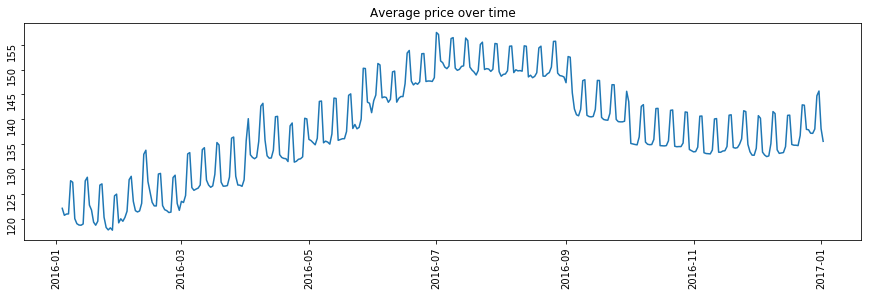

In [39]:
cal[cal.available == 't'].groupby(['date'], as_index= False)['price'].mean()
fig, ax1 = plt.subplots(1,1, figsize = (15,4))

ax1.plot(cal[cal.available == 't'].groupby(['date'], as_index= False)['price'].mean().date, cal[cal.available == 't'].groupby(['date'], as_index= False)['price'].mean().price)
ax1.tick_params(labelrotation=90)
plt.title('Average price over time');
plt.savefig('pictures/Average Price over time')

In [40]:
cal['day_of_week'] = cal['date'].dt.weekday
cal['day_name'] = cal['date'].dt.day_name()

cal['month'] = cal['date'].dt.month

## Plot amount of listings over time

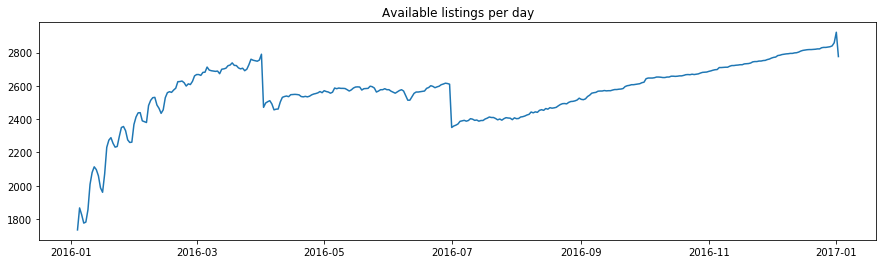

In [41]:
fig, ax1 = plt.subplots(1,1, figsize = (15,4))
count_list = cal[cal.available == 't'].groupby(['date'], as_index = False)['listing_id'].count()
plt.plot(count_list.date, count_list.listing_id)
plt.title('Available listings per day');
plt.savefig('pictures/Available listings per day')

## Plot cost per weekday vs. listings per weekday

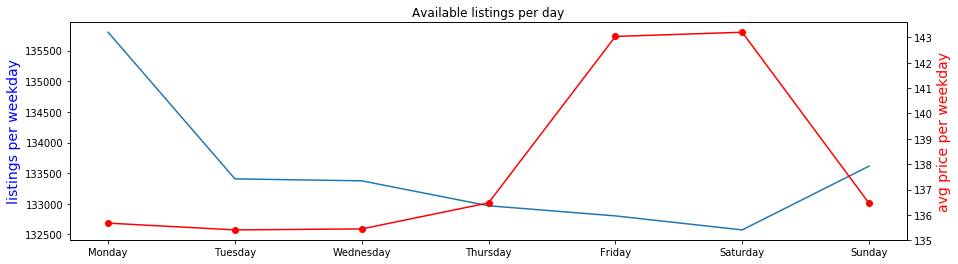

In [42]:
fig, ax1 = plt.subplots(1,1, figsize = (15,4))
count_list = cal[cal.available == 't'].groupby(['day_of_week','day_name'], as_index = False).agg({'listing_id':'count', 'price':'mean'})
ax1.plot(count_list.day_name, count_list.listing_id)
ax1.set_ylabel("listings per weekday",color="blue",fontsize=14)
ax2 = ax1.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(count_list.day_name, count_list.price,color="red",marker="o")
ax2.set_ylabel("avg price per weekday",color="red",fontsize=14)
#plt.plot(count_list.day_name, count_list.price)
plt.title('Available listings per day');
plt.savefig('pictures/Average Price per weekday')

# NLP analysis

## find describing adjectives of listing

### Tokenize listing description

In [44]:
adjective_tags = ["JJ", "JJR", "JJS"]
tokenized_sents = [word_tokenize(i) for i in listings.description]


In [46]:
final_adj = []

for sentence, sent in zip(tokenized_sents,listings.description):
    close = []
    adj = [word[0].lower() for word in nltk.pos_tag(sentence) if word[1] in adjective_tags]
    sentence = [word.lower() for word in sentence]
    names = ['apartment', 'apartments','house', 'houses', 'suite', 'cabin', 'cabins', 'bungalow', 'space', 'home', 'camper', 'cottage', 'farmhouse', 'room', 'studio', 'bedroom', 'kitchen', 'guesthouse']
    for name in names:
        if name in sentence:
            indexes = [i for i,x in enumerate(sentence) if x == name]
            for ind in indexes:
                temp = sentence[ind-min(9,ind) :ind +9] 
                temp = [w.lower() for w in temp]
                close.extend([word for word in adj if word in temp])
    final_adj.extend(set(close))
    if '*' in final_adj:
        final_adj.remove('*')
final_adj.append('luxurious')
adj_df = pd.DataFrame({'adjective':final_adj})

In [47]:
final_adj = adj_df.adjective.value_counts().head(50)
final_adj = pd.DataFrame({'adjective':final_adj.index, 'adj_count':final_adj})

In [48]:

col_names = []
final_adj['avg_price'] = 0
for adj in final_adj['adjective']:
    name = 'aprtmnt_adj_' + adj
    col_names.append(name)
    lis[name] = listings.description.str.contains(adj)
    final_adj.loc[adj,'avg_price'] = lis[lis[name] == True].price.mean()


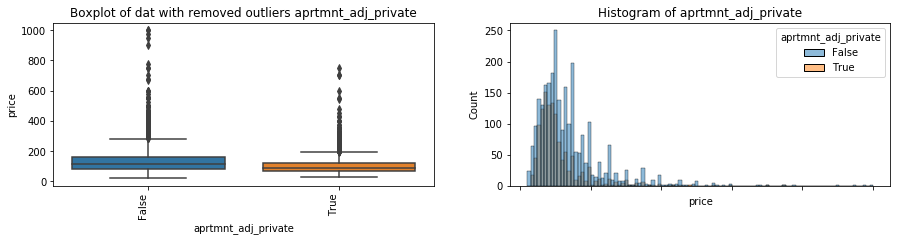

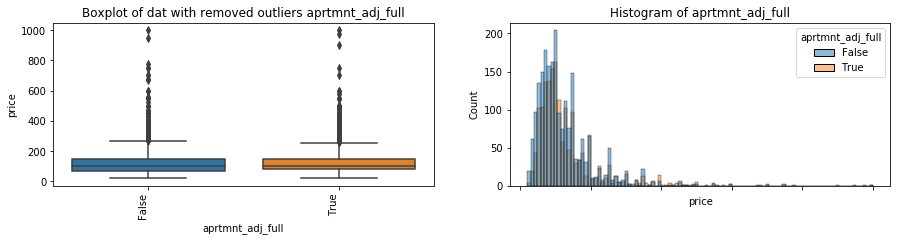

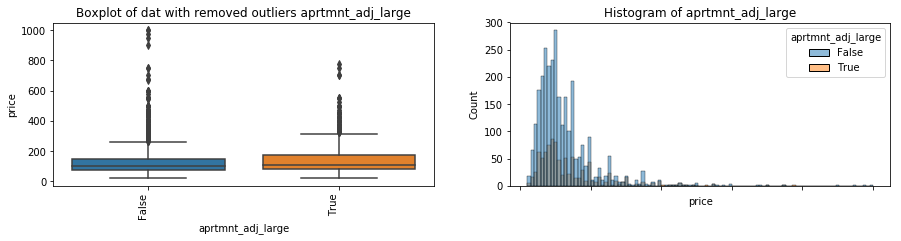

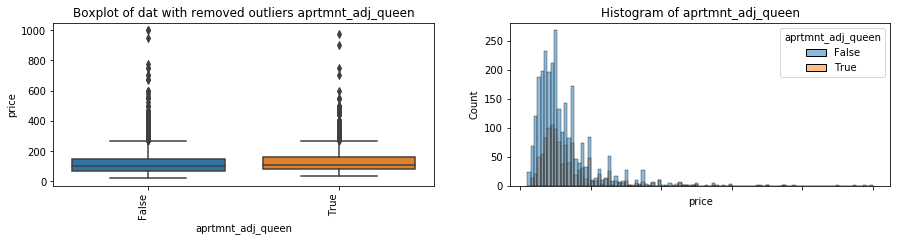

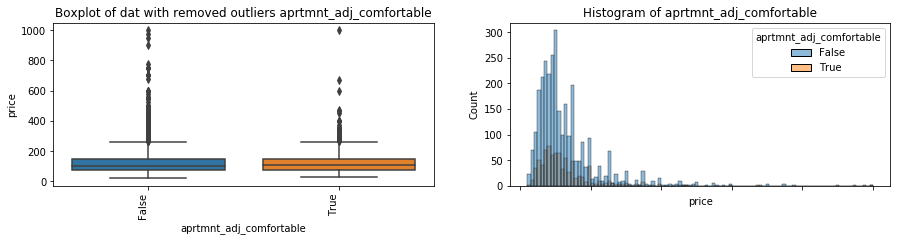

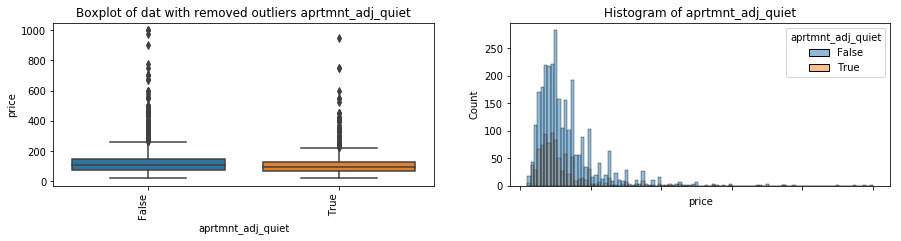

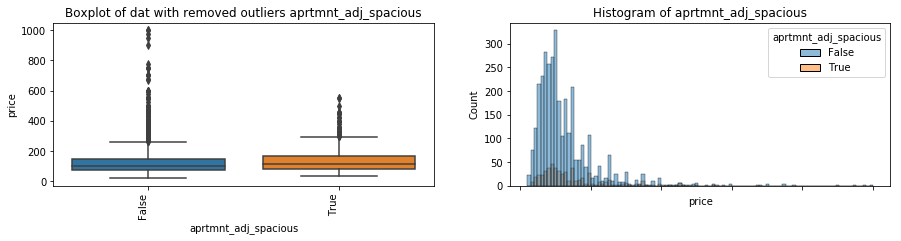

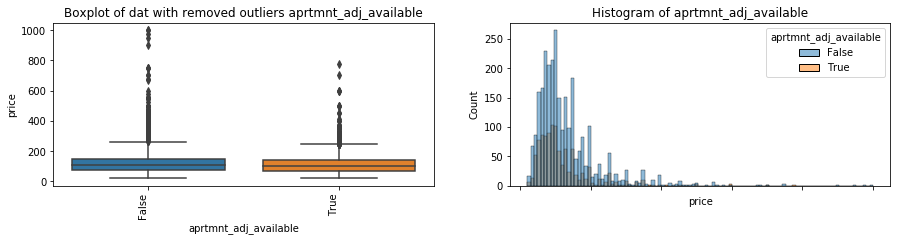

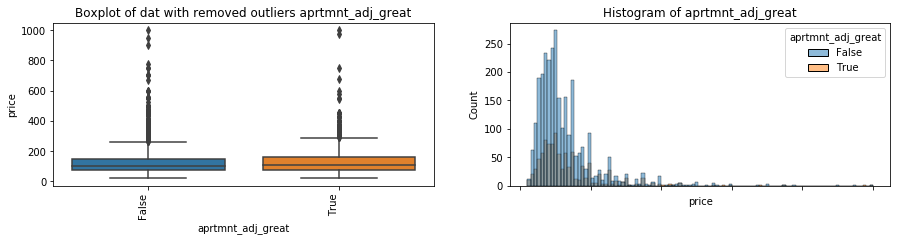

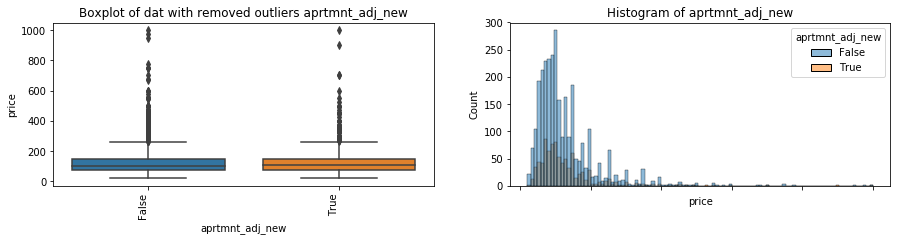

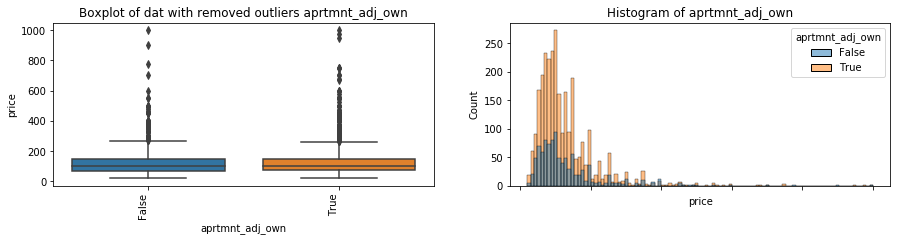

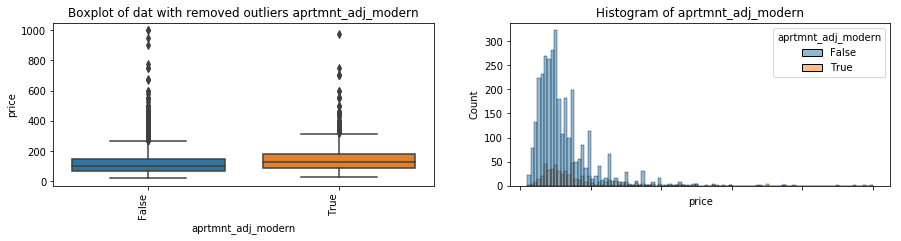

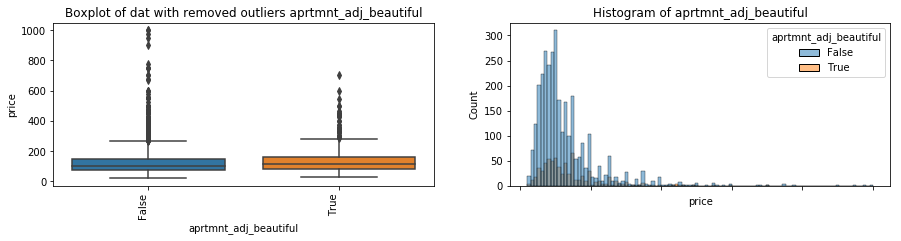

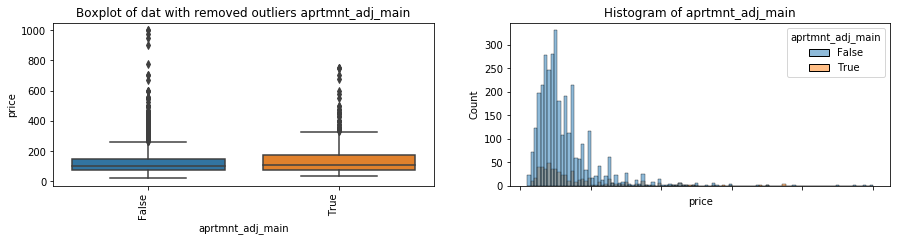

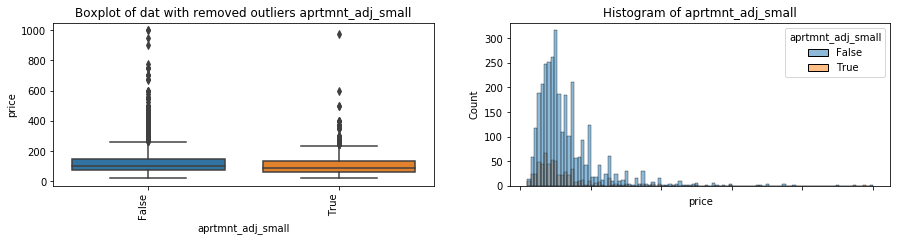

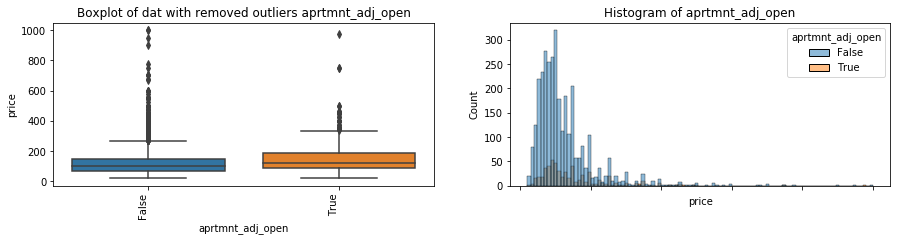

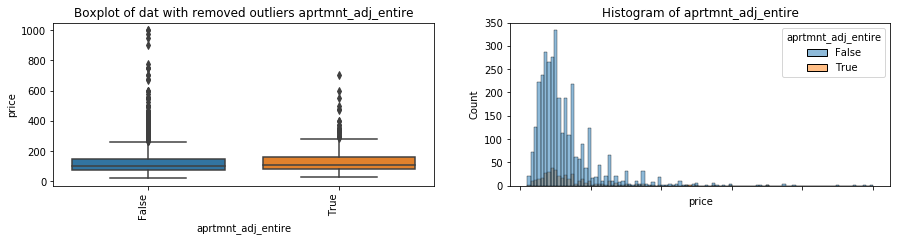

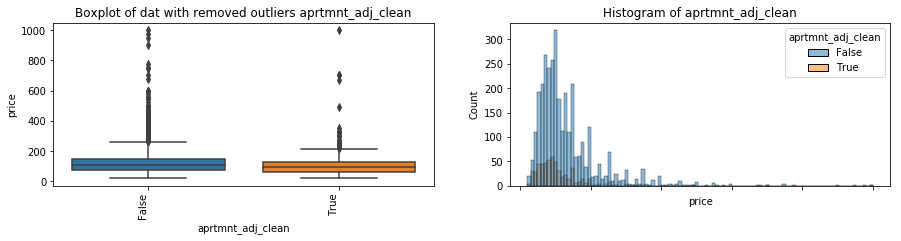

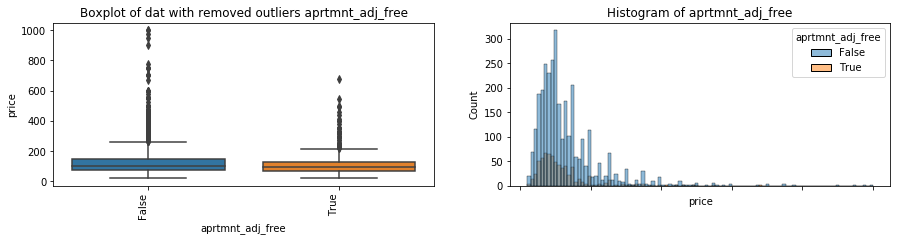

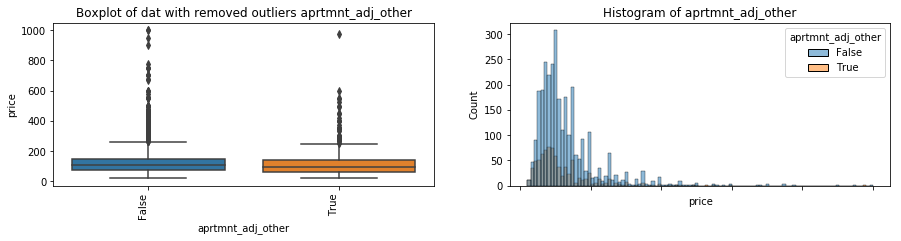

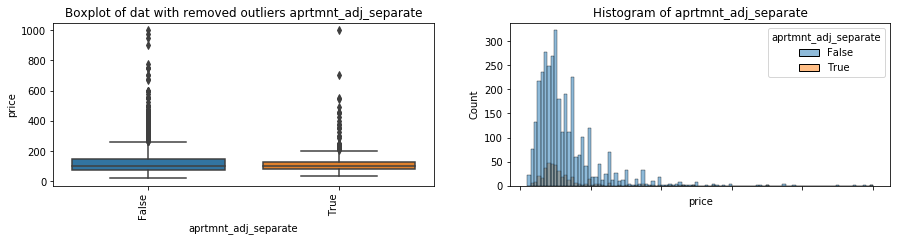

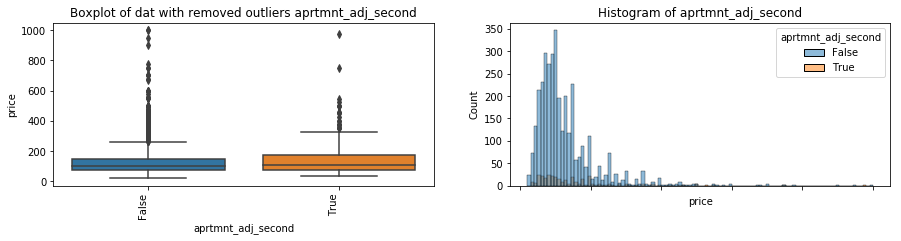

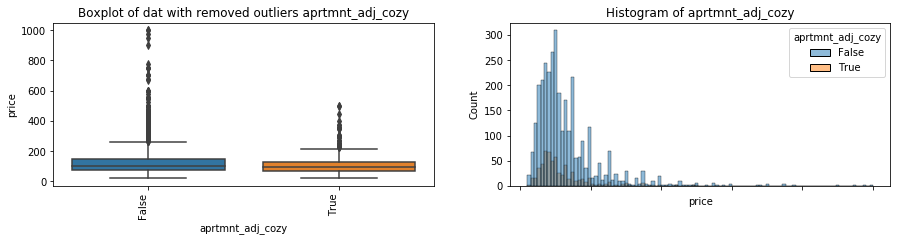

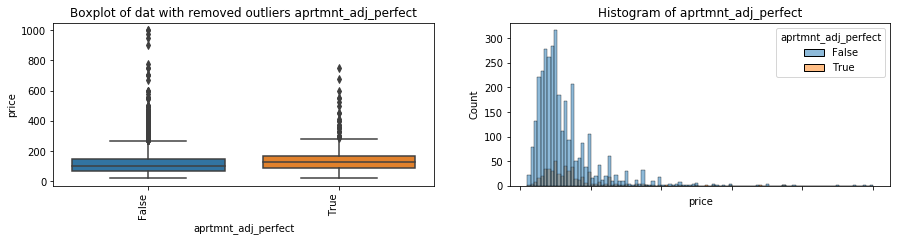

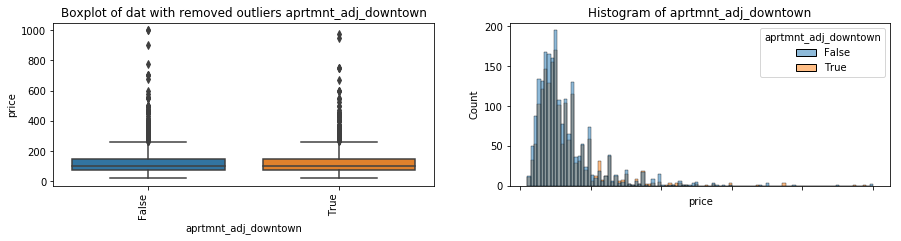

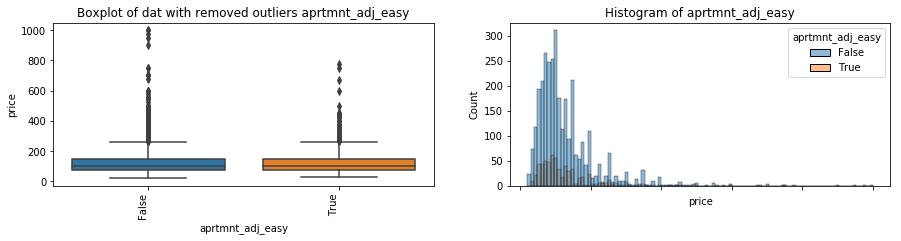

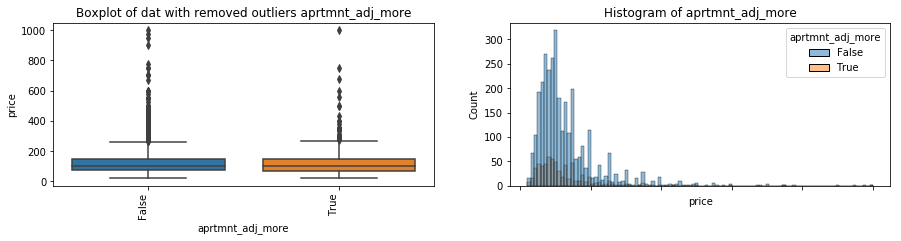

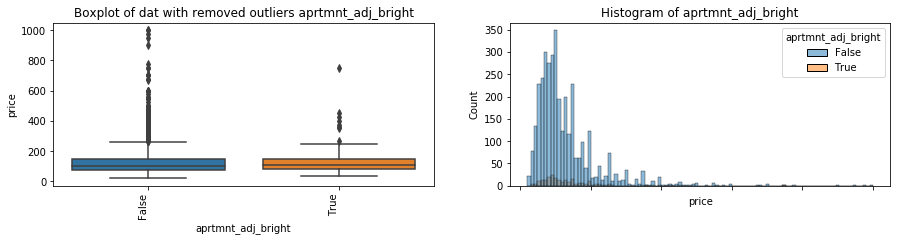

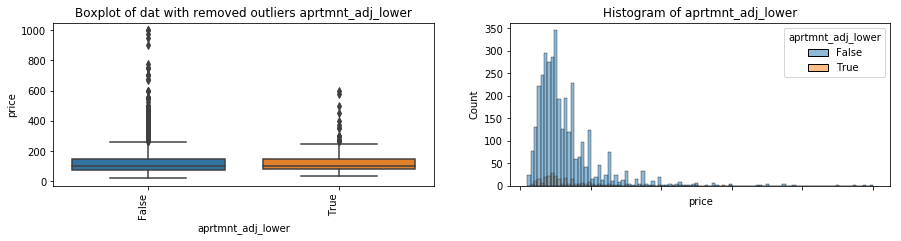

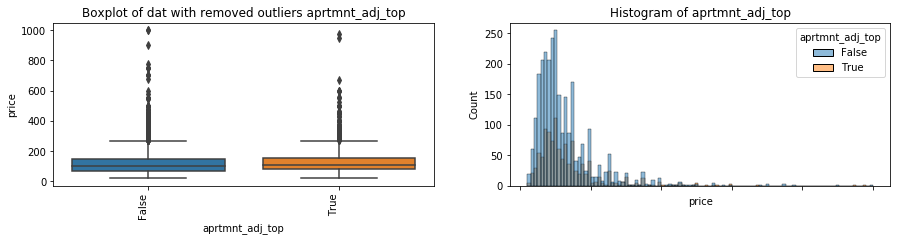

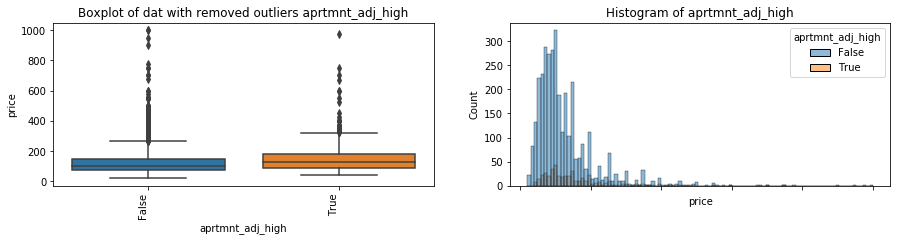

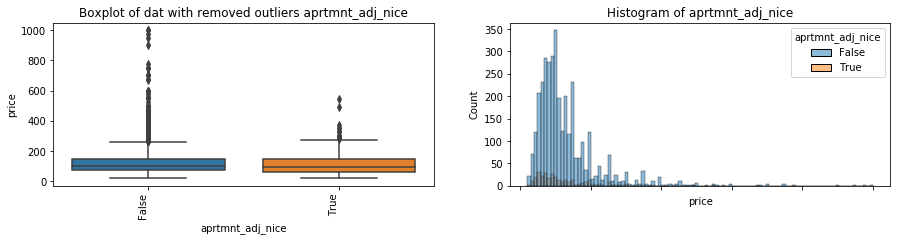

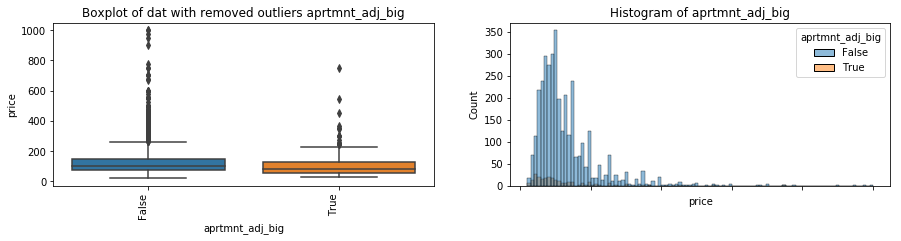

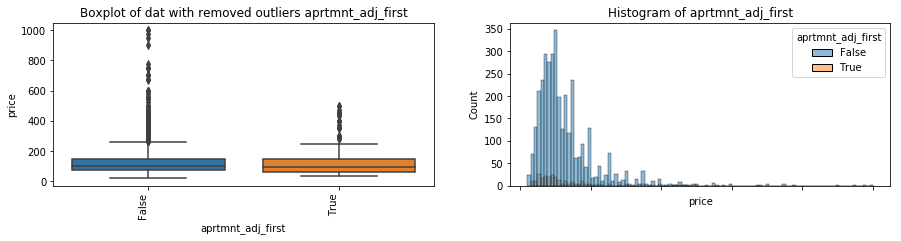

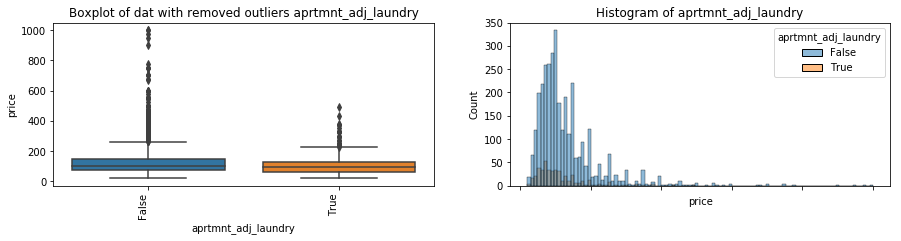

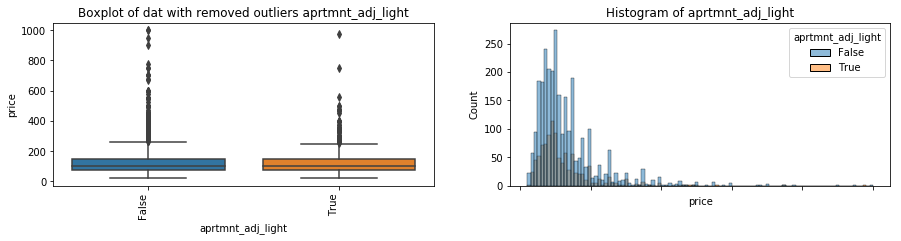

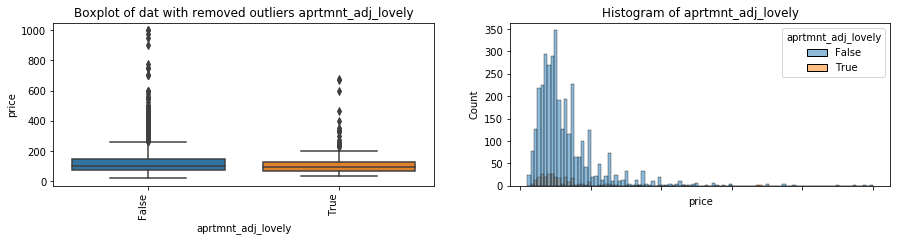

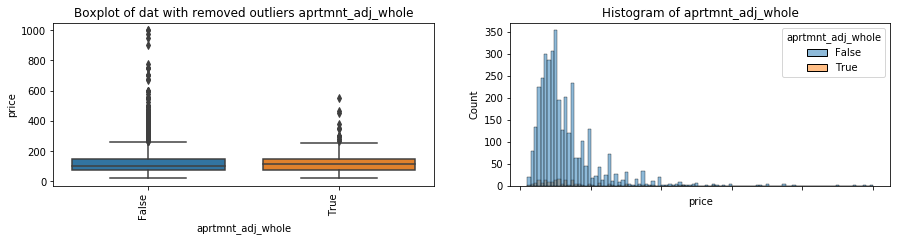

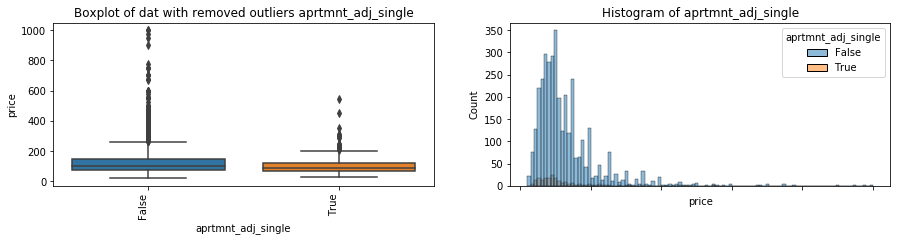

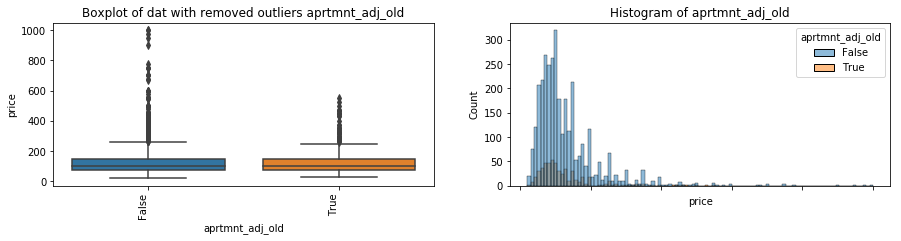

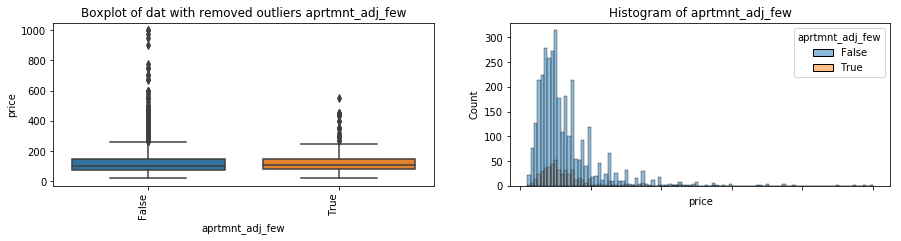

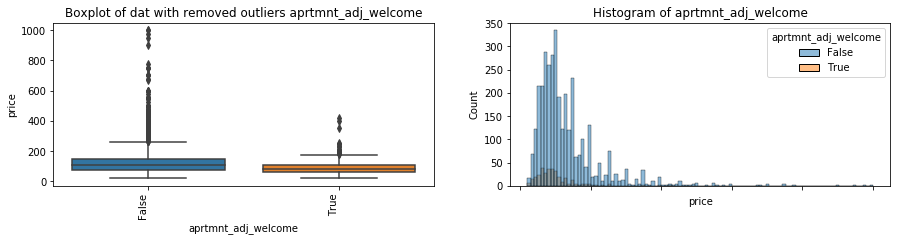

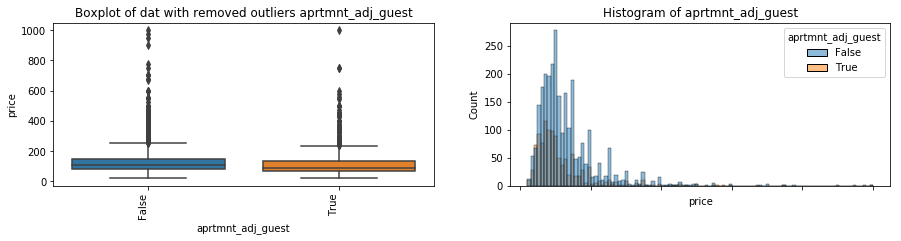

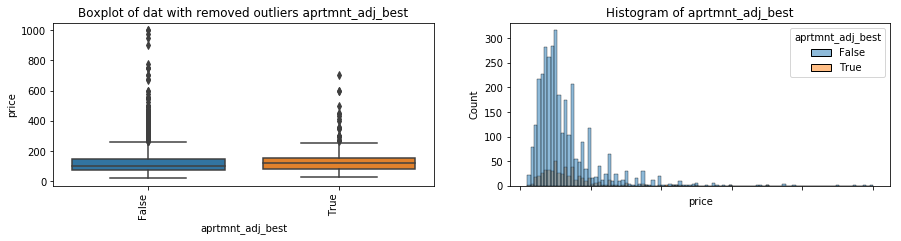

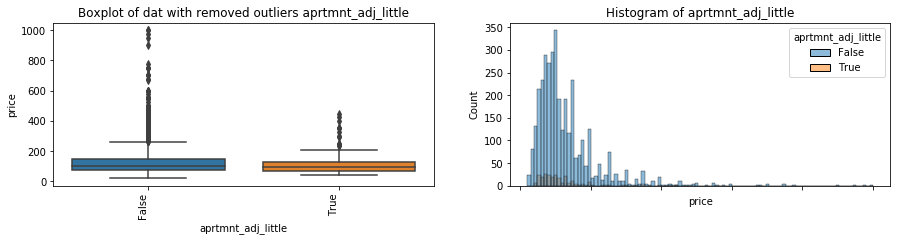

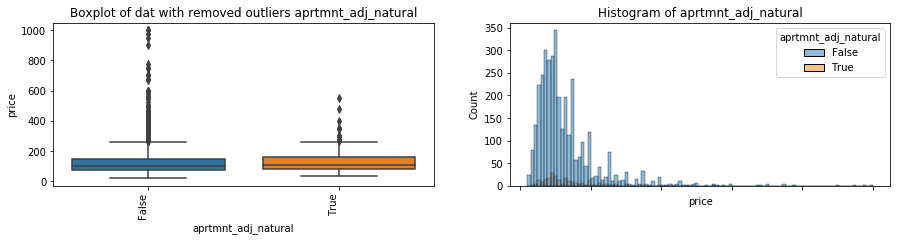

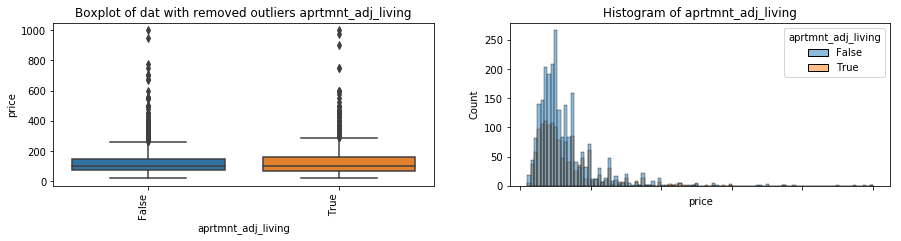

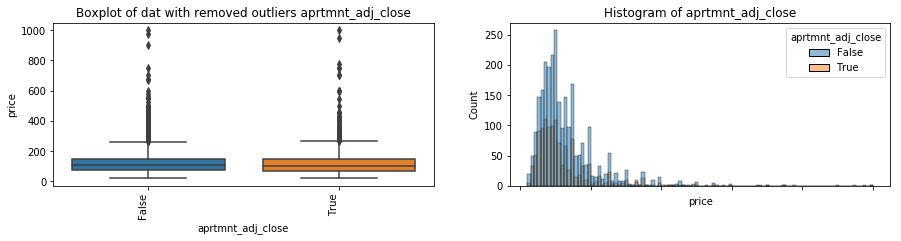

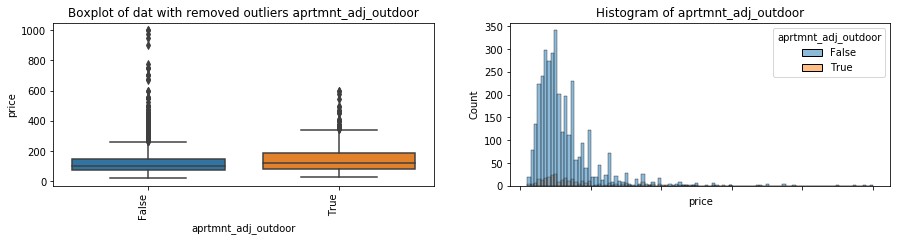

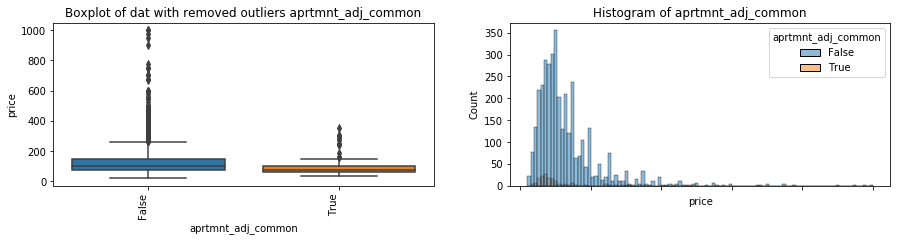

In [49]:
for col in col_names:
    fig, ax = plt.subplots(1,2, figsize = (15,3))
    g1 = sns.boxplot(ax = ax[0], x=col, y="price", data=lis)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90, horizontalalignment='right')
    g1.set_title('Boxplot of dat with removed outliers ' + col)
    g2 = sns.histplot(ax = ax[1], x="price", data = lis, hue = col)
    g2.set_xticklabels(g2.get_xticklabels(), rotation=90, horizontalalignment='right')
    g2.set_title('Histogram of ' + col)

## Find describing adjectives of location

**Can I learn anything about Seattle's neighbourhoods without knowing the city?**
Yes! Because Python and its libraries are amazing! I have tried natural language processing for the very first time and I am already able to describe the different neighborhoods. Do you know Seattle? If yes, I hope you agree with my findings.
What are you looking for?
* A quiet neighbourhood? Go to **Magnolia or Delridge**
* Local restaurants and bars? Go to **University District** or **Ballard**
* Residential Area? **Beacon Hill, Delridge**
* Most Popular? **University District**
* Walkable? **Lake city, Ballard**
* Vibrant? **University District**
* Diverse? **University District, Rainler Valley**
* Famous Sightseeing? **Queen Anne**



Find list of adjectives in neighborhood_overview column

### Tokenize neighbourhood description

Create list, which contains all adjectives from all neighbourhood descriptions (which NLP identifies) to find the most common adjectives

In [59]:
listings.neighborhood_overview.fillna('',inplace = True)
tokenized_sents = [word_tokenize(i) for i in listings.neighborhood_overview.dropna()]

In [57]:
final_adj = []
listings['tokenized_neighbourhood'] = tokenized_sents
for sentence, sent in zip(tokenized_sents,listings.neighborhood_overview.dropna()):
    close = []
    adj = [word[0].lower() for word in nltk.pos_tag(sentence) if word[1] in adjective_tags]
    sentence = [word.lower() for word in sentence]
    final_adj.extend(adj)
    if '*' in final_adj:
        final_adj.remove('*')
    
adj_df = pd.DataFrame({'adjective':final_adj})

In [60]:
adj_df.head()

adjective
0       queen
1   wonderful
2  functional
3    charming
4        full

Drop not important or unclear adjectives

In [61]:
top_adj_loc = adj_df[~(adj_df.adjective.isin(['great','many', 'best', 'few', 'other', 'more', 'several', 'right', 'good', 'most', 'less']))]['adjective'].value_counts().head(20)
top_adj_loc

quiet          521
easy           368
local          339
short          293
downtown       270
beautiful      247
residential    226
close          210
safe           164
popular        163
public         158
amazing        149
walkable       147
vibrant        135
friendly       126
wonderful      125
diverse        124
nearby         123
small          123
famous         123
Name: adjective, dtype: int64

### Create dataframe with mean amount of mentions per adjective

In [62]:
listings.neighborhood_overview.fillna('', inplace = True)
location_final = pd.DataFrame({'adjective':top_adj_loc.index.tolist()})
for col in list(listings.neighbourhood_group_cleansed.unique()):
    location_final[col] =0

for name in list(listings.neighbourhood_group_cleansed.unique()):
    for adj in location_final.adjective:
        location_final[name].loc[location_final.adjective == adj] = listings[listings.neighbourhood_group_cleansed == name].neighborhood_overview.str.contains(adj).mean()

In [63]:
district_melt = pd.melt(location_final, id_vars=['adjective'], value_vars=list(listings.neighbourhood_group_cleansed.unique()))
district_melt.head()

adjective    variable     value
0     quiet  Queen Anne  0.101695
1      easy  Queen Anne  0.098305
2     local  Queen Anne  0.040678
3     short  Queen Anne  0.061017
4  downtown  Queen Anne  0.305085

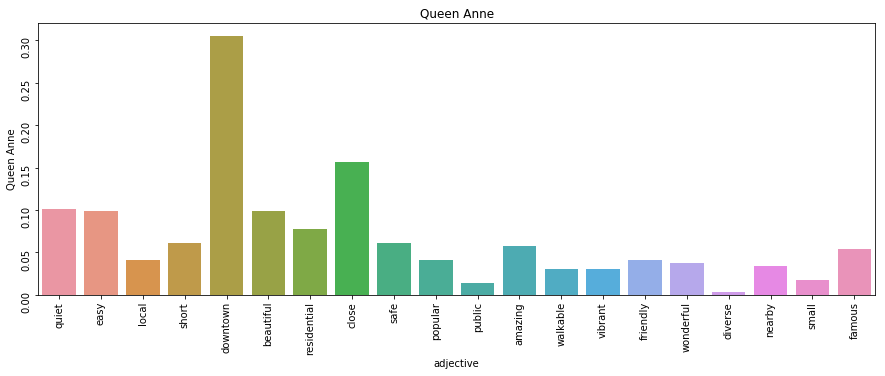

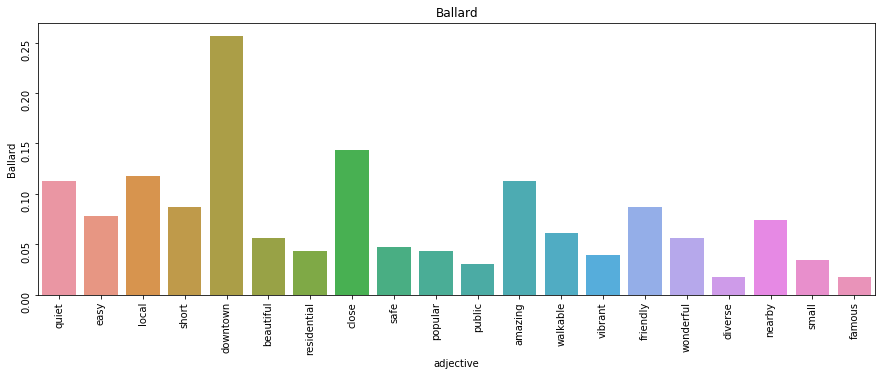

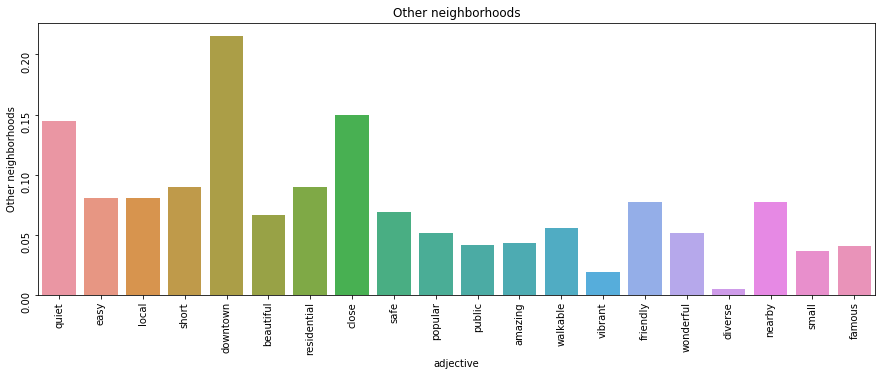

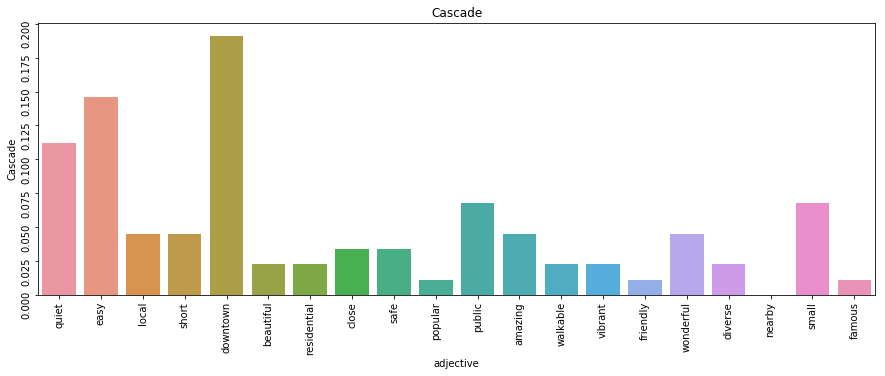

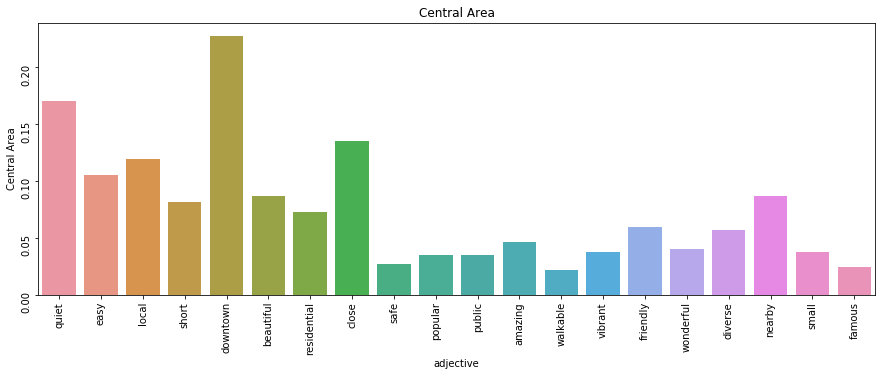

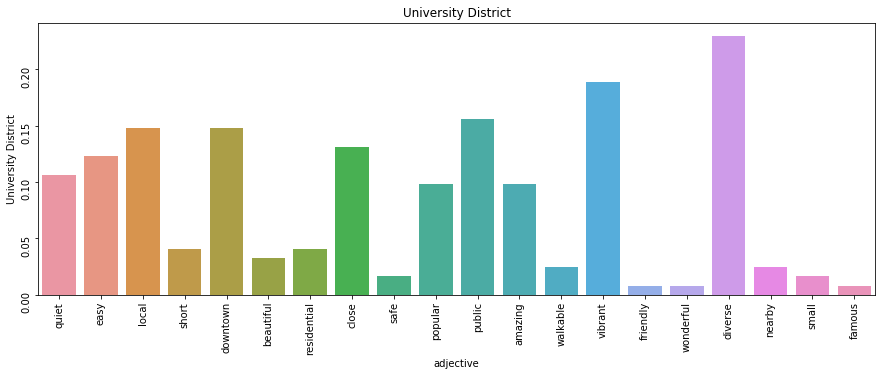

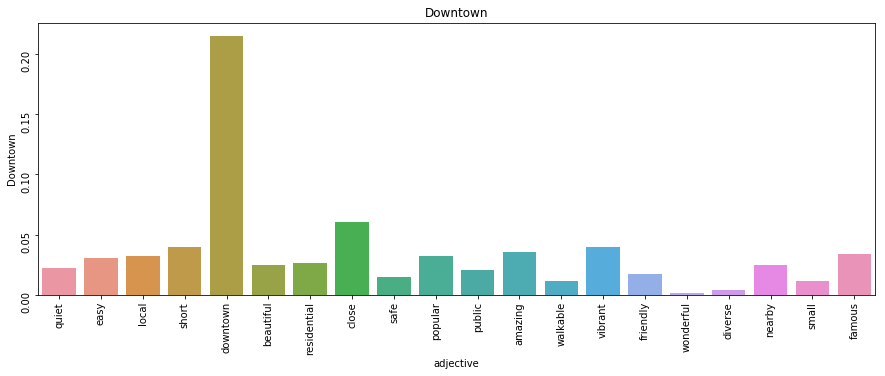

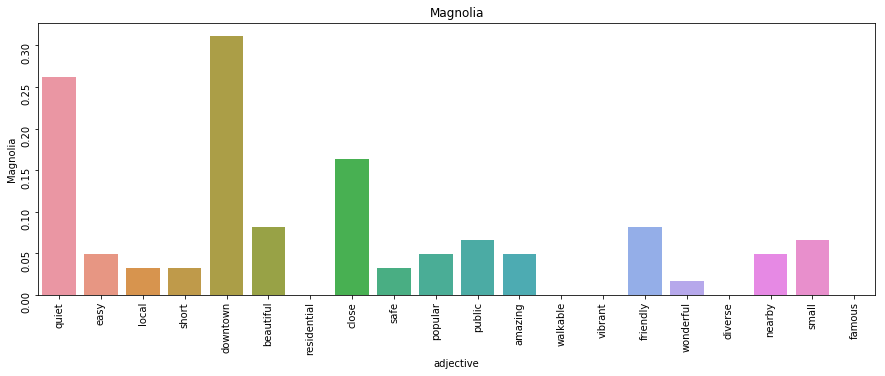

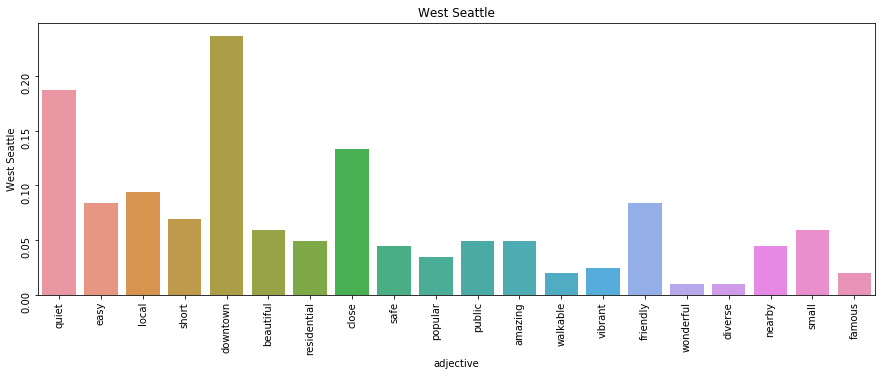

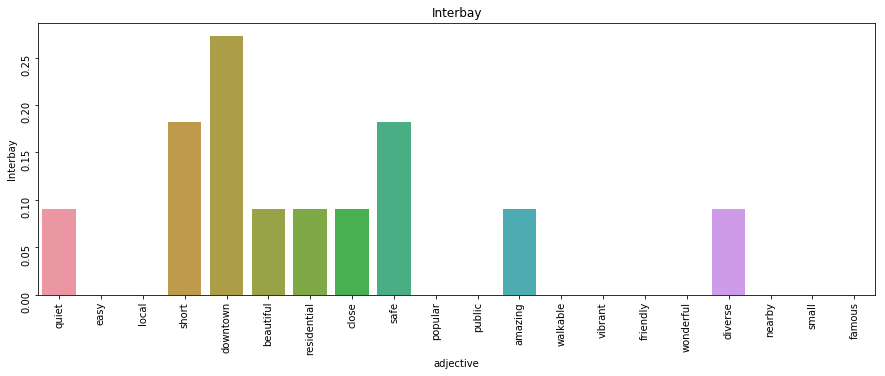

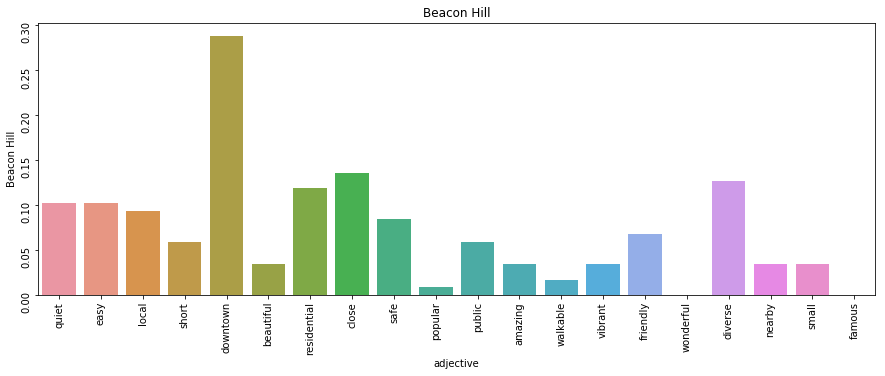

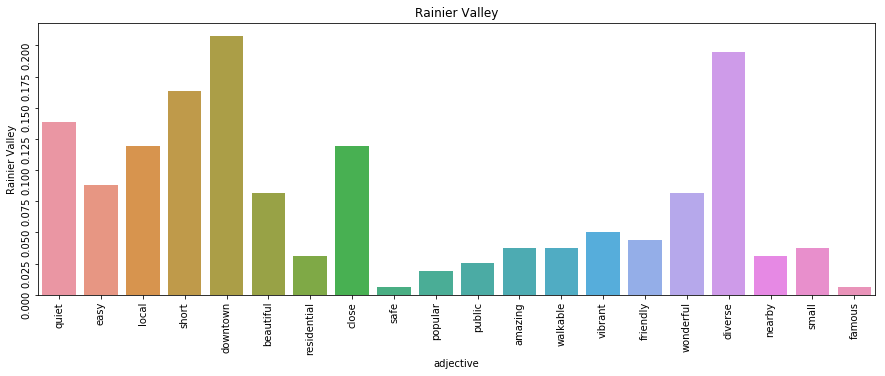

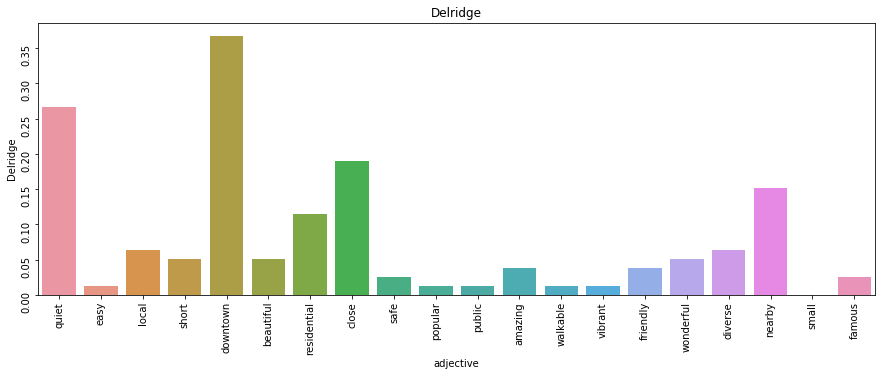

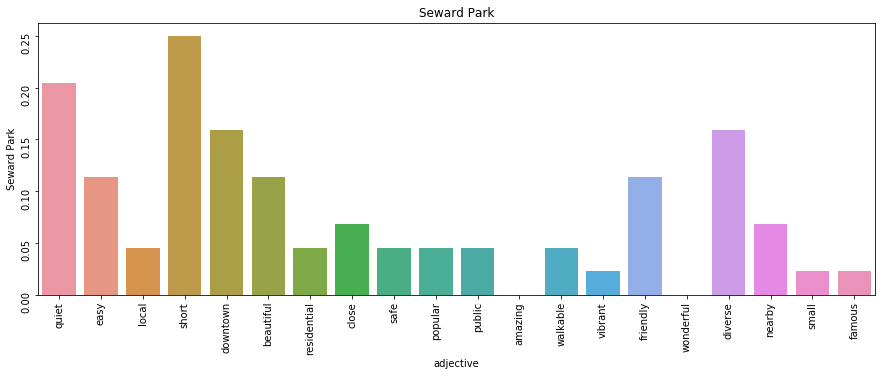

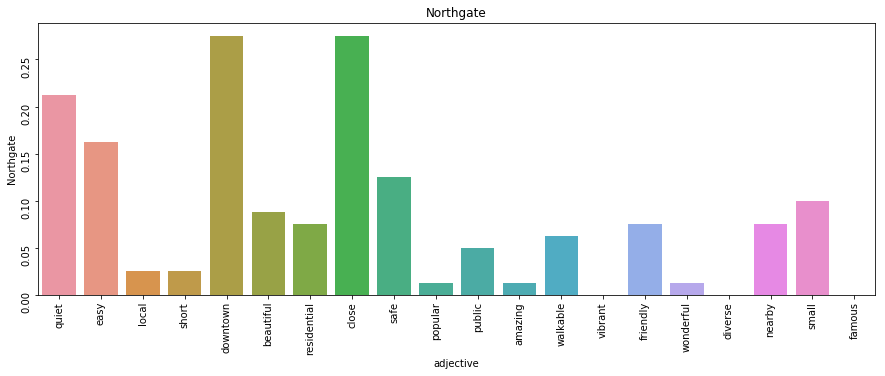

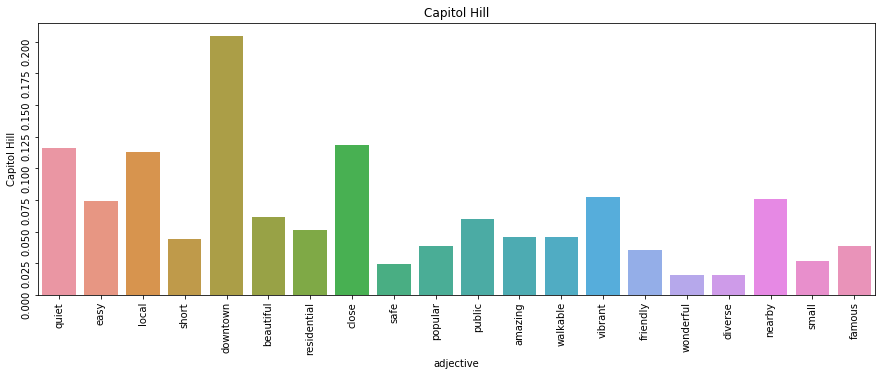

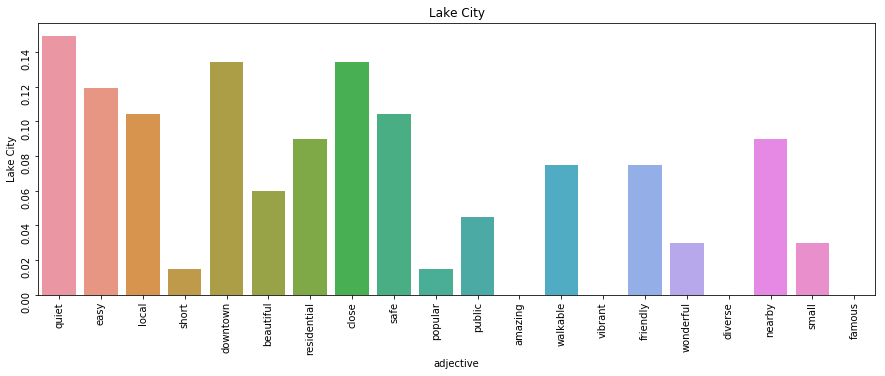

In [64]:
for name in list(listings.neighbourhood_group_cleansed.unique()):
    fig,ax = plt.subplots(1,1,figsize=(15,5))
    sns.barplot(x=location_final['adjective'], y=location_final[name])
    ax.tick_params(labelrotation=90)
    plt.title(name)

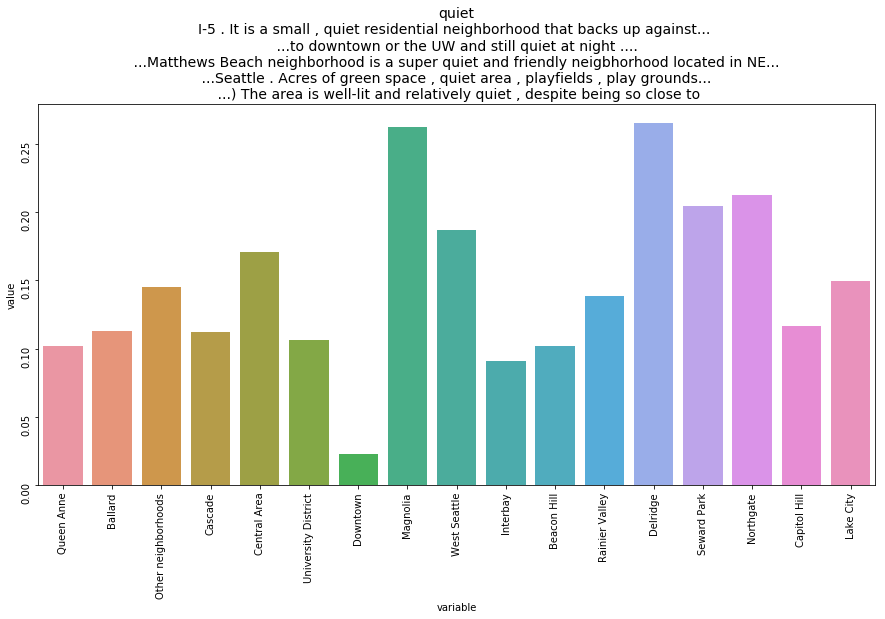

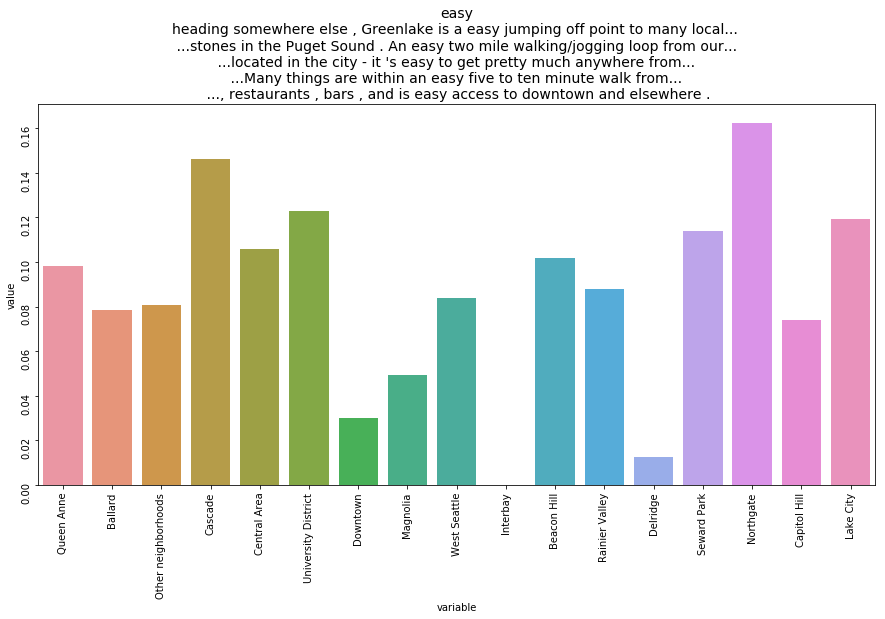

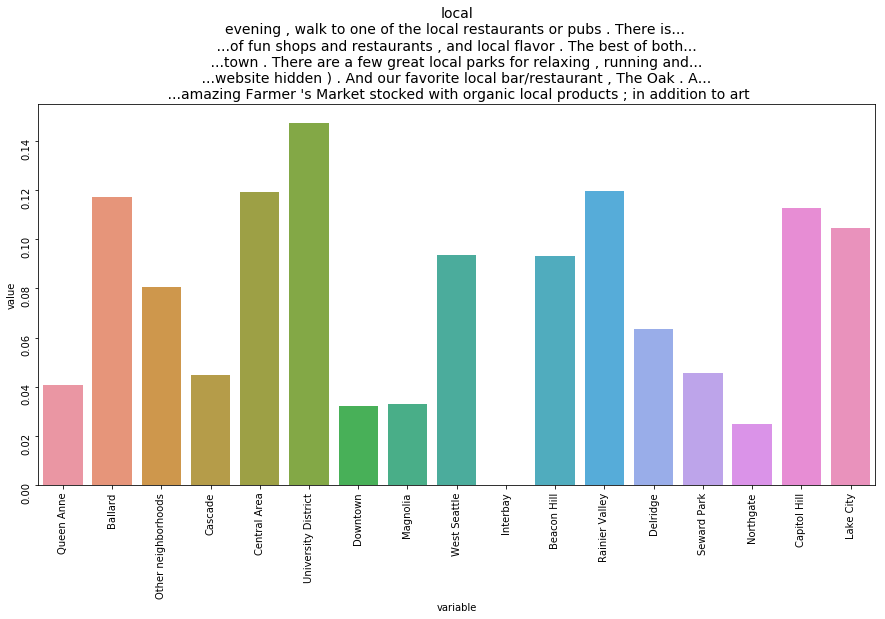

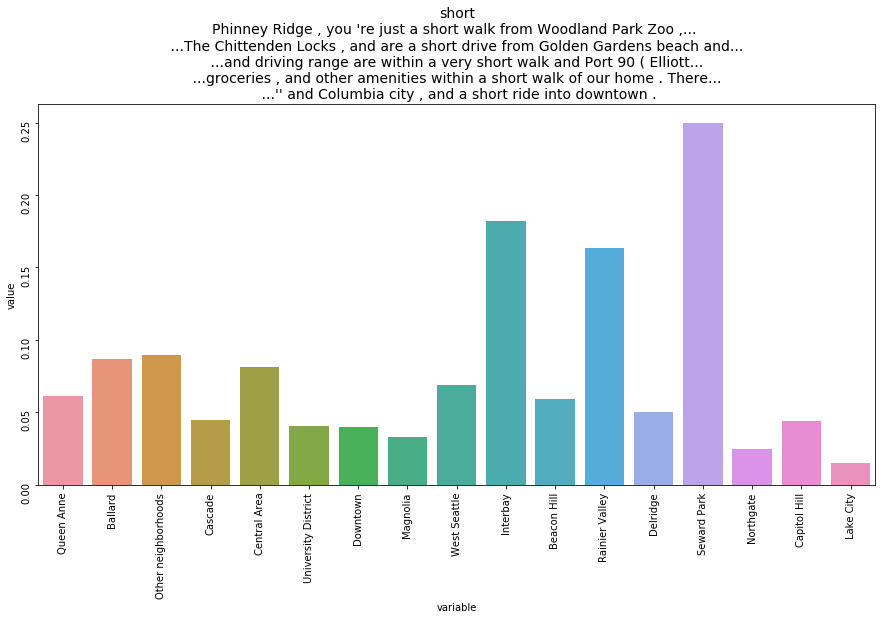

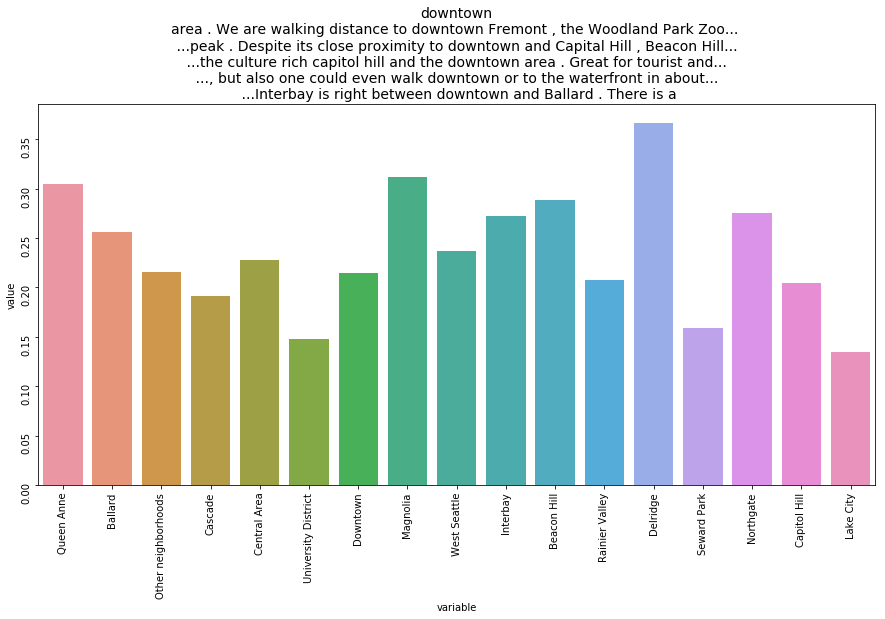

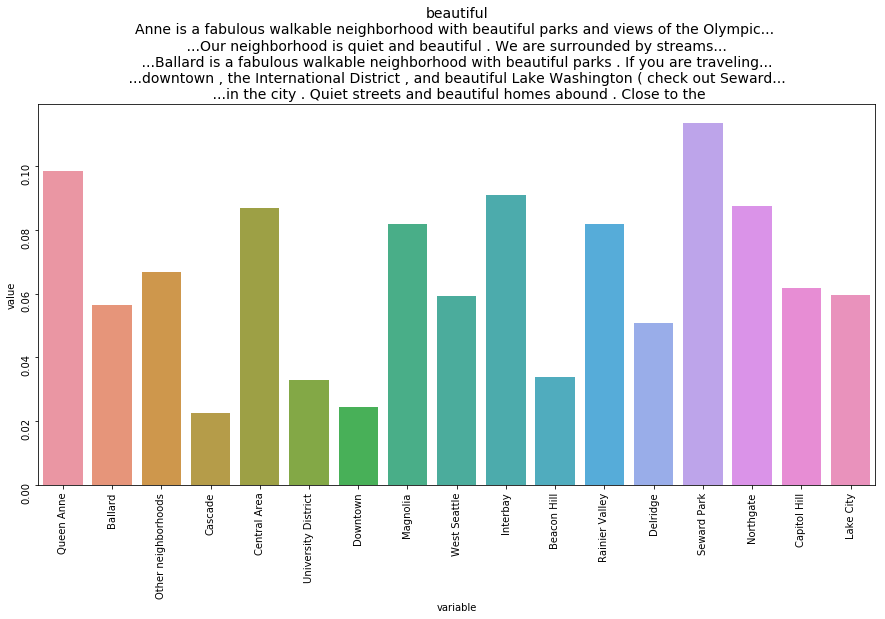

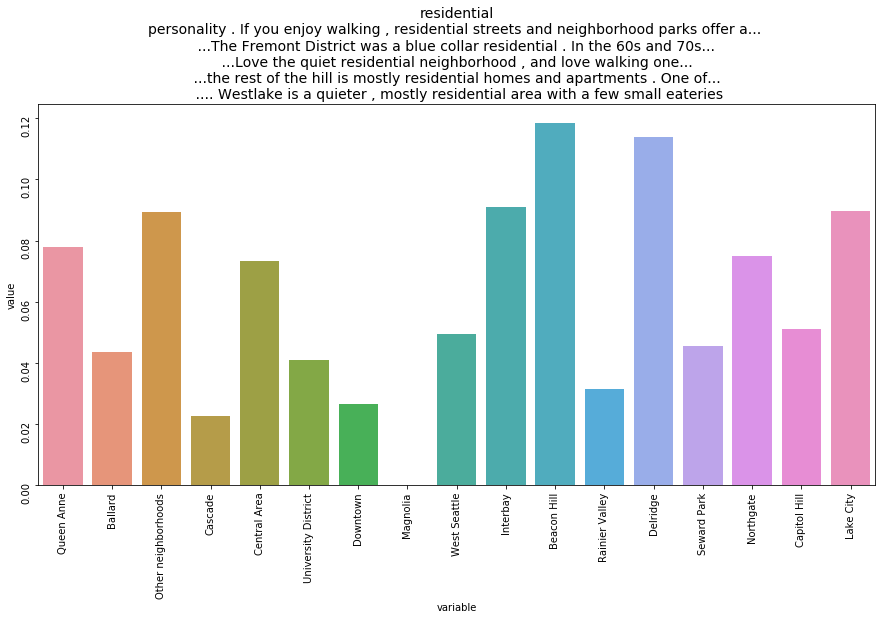

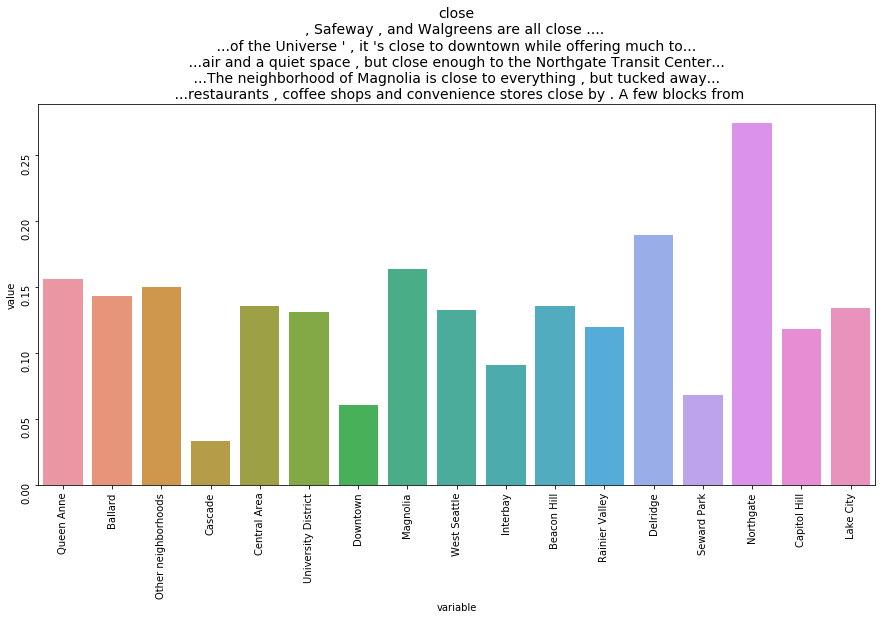

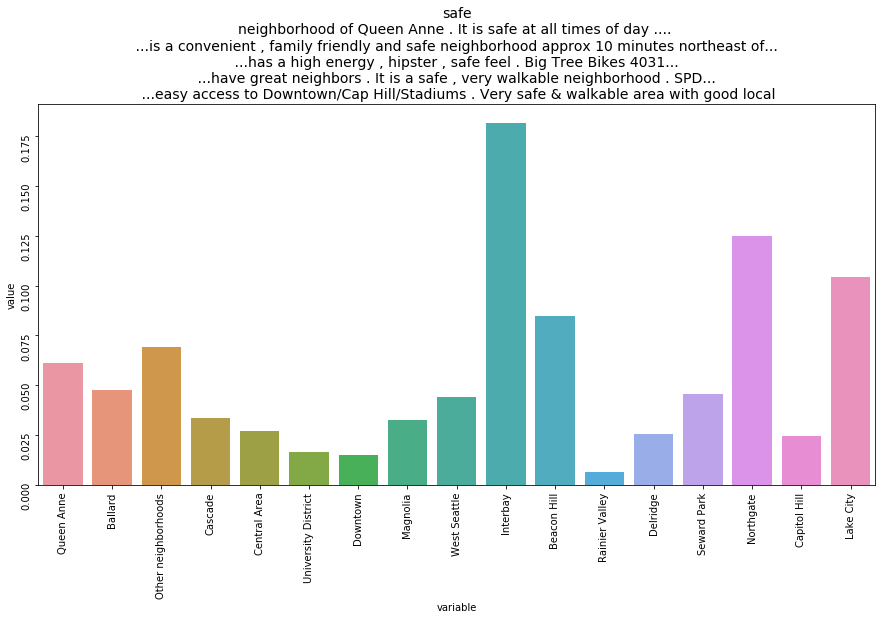

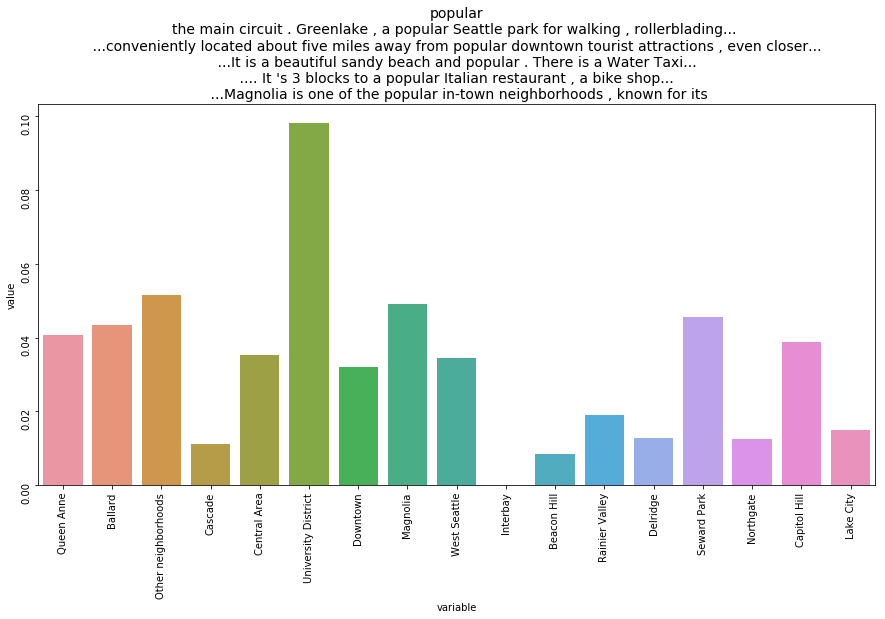

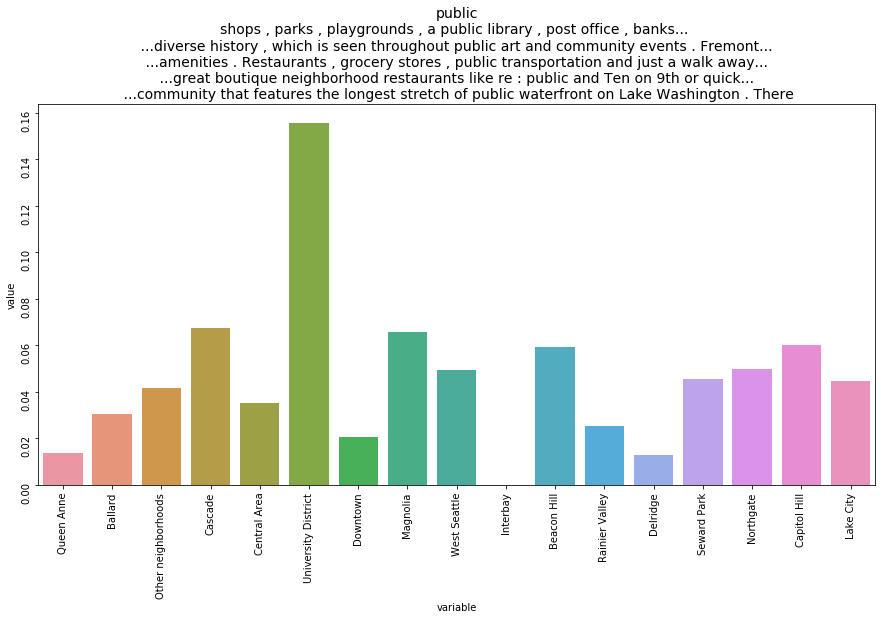

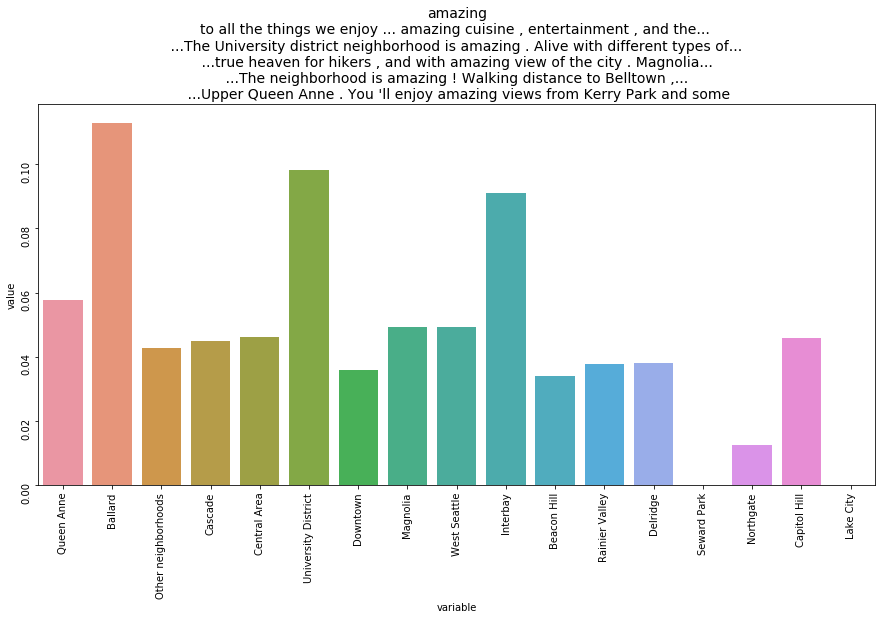

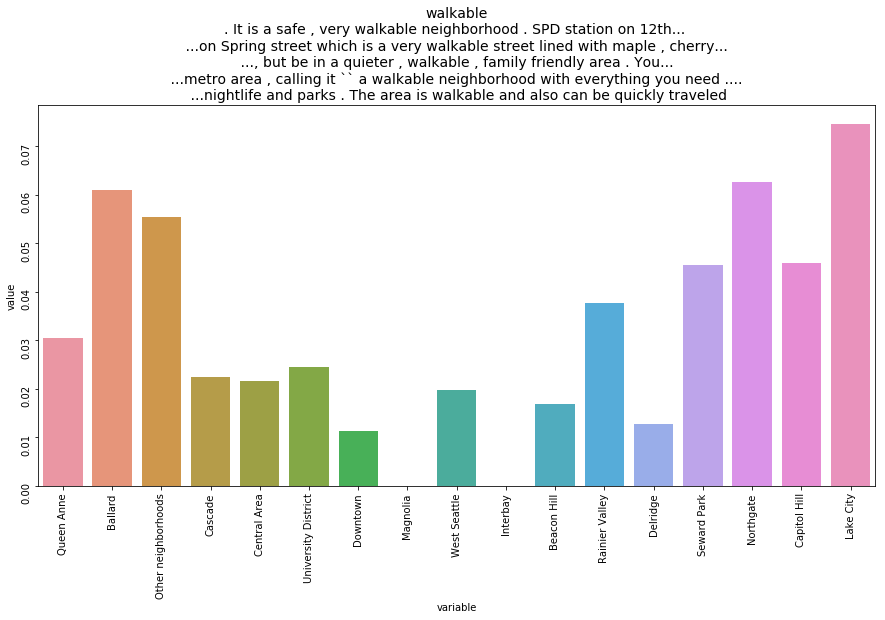

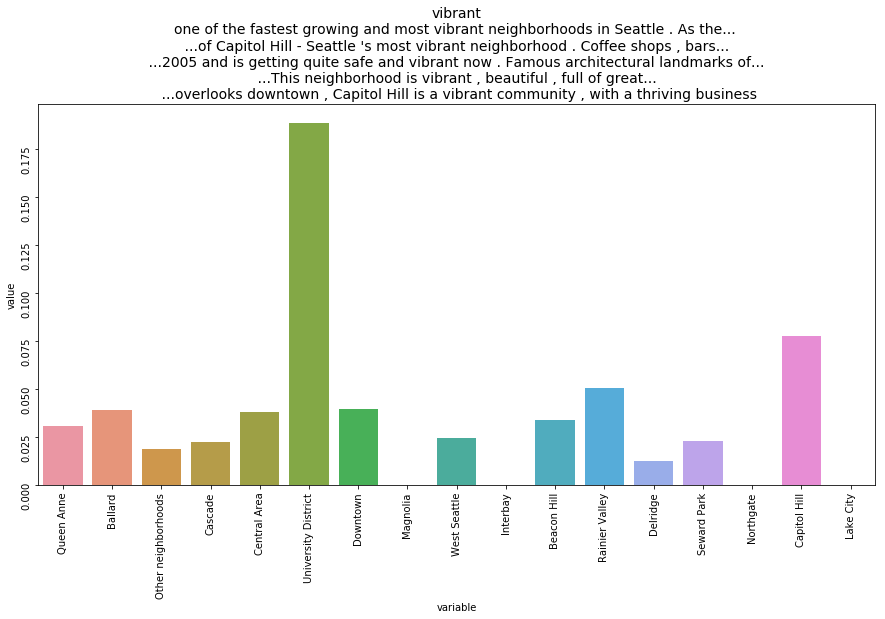

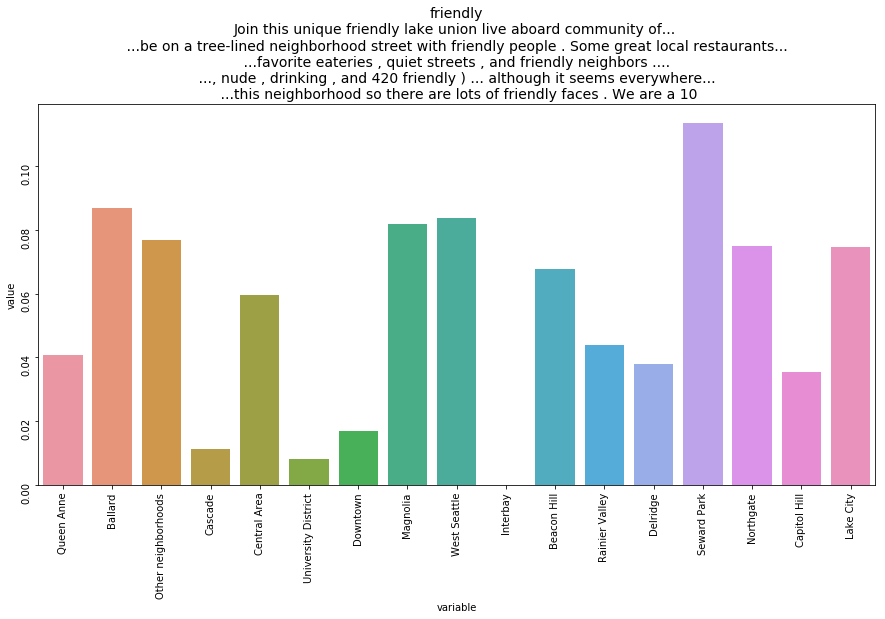

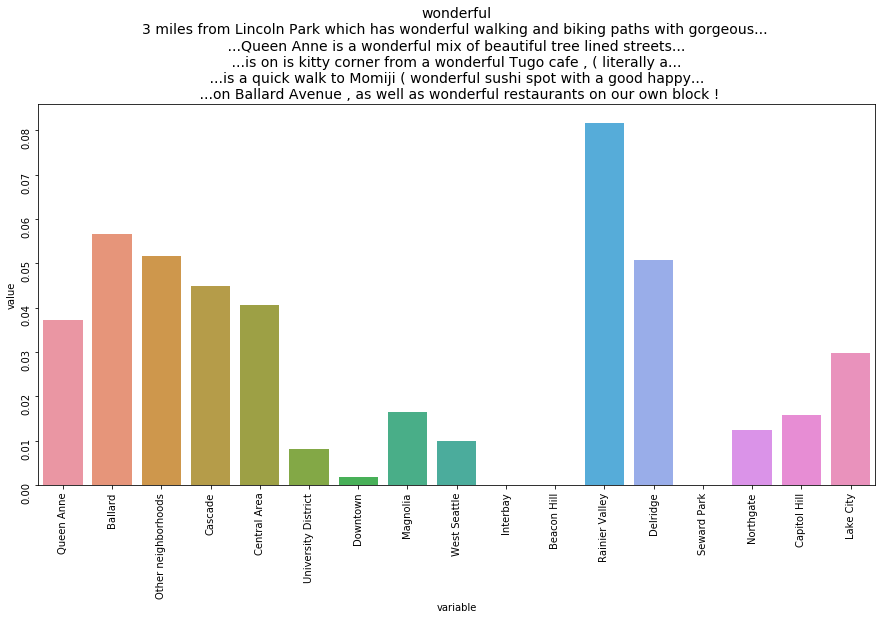

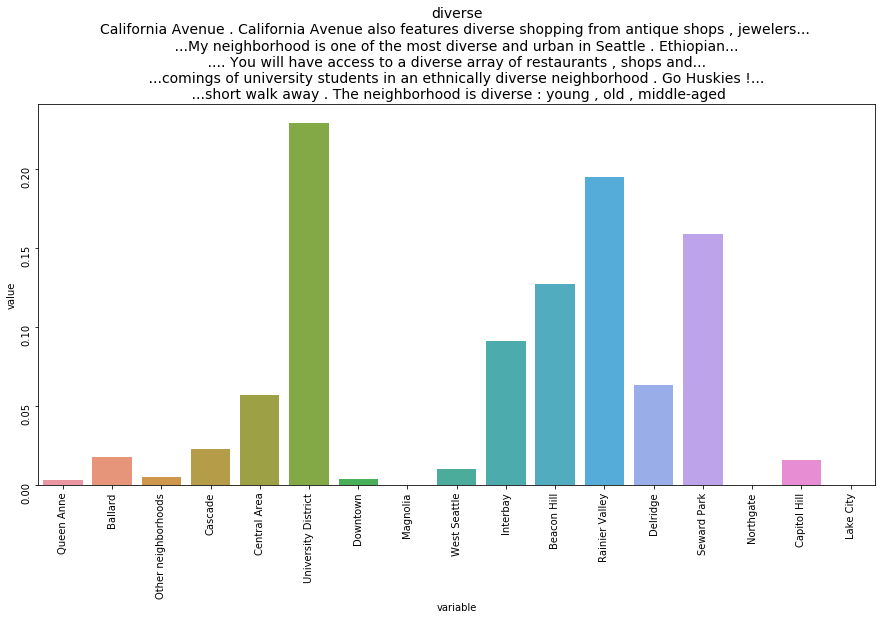

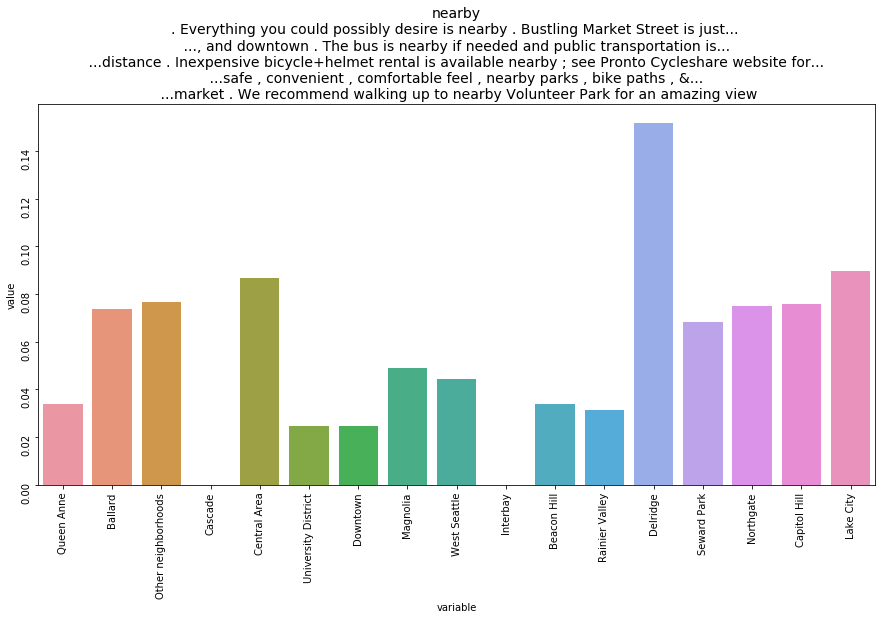

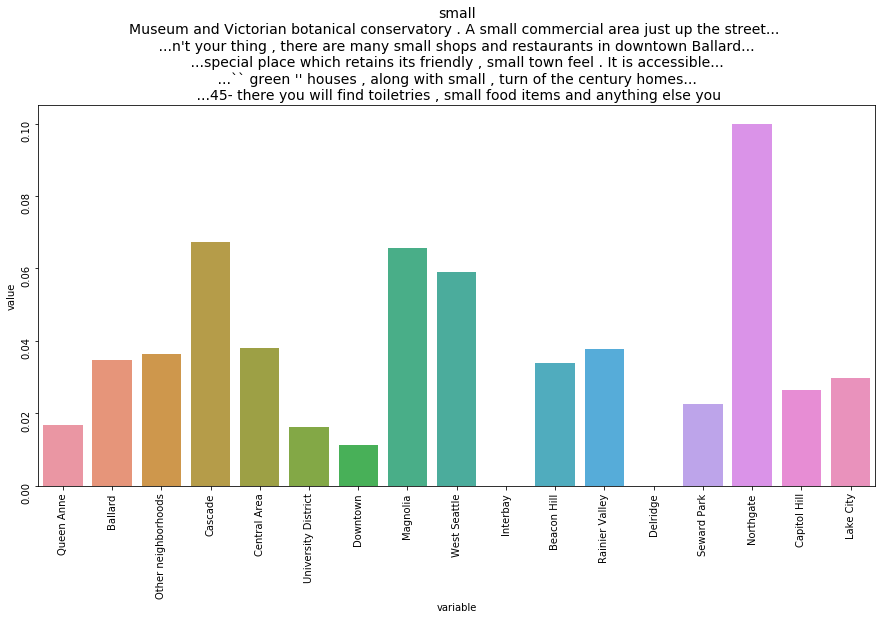

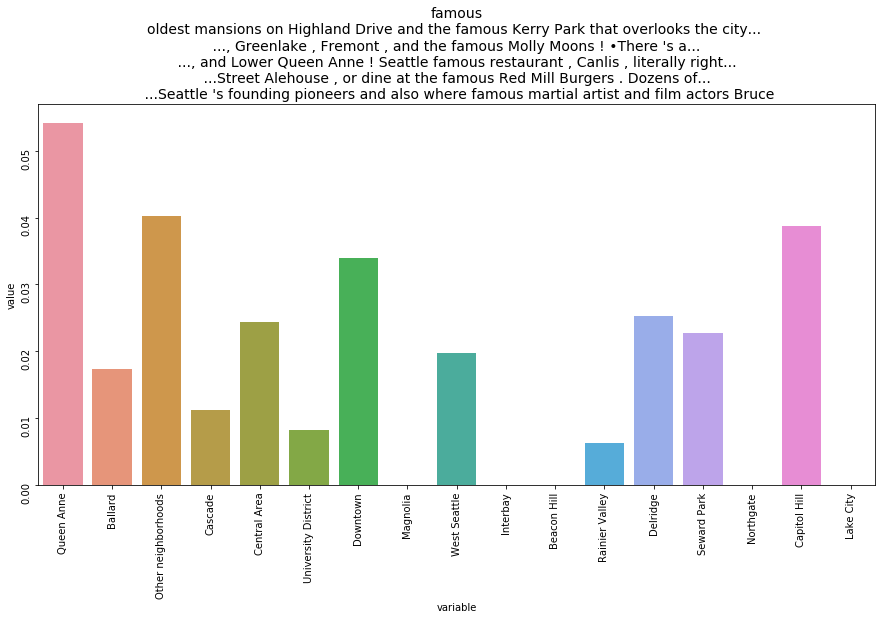

In [65]:
for adj in list(location_final['adjective'].unique()):
    fig,ax = plt.subplots(1,1,figsize=(15,7))
    textstr = '... \n ...'.join((
        [' '.join(sentence[sentence.index(adj)-min(7,sentence.index(adj)) :sentence.index(adj) +7]) for sentence in listings[[len(set([adj]).intersection(set(x)))>0 for x in listings.tokenized_neighbourhood]].tokenized_neighbourhood.sample(5, random_state = 42)]

        ))
    sns.barplot(x=district_melt[district_melt.adjective == adj]['variable'], y=district_melt[district_melt.adjective == adj]['value'])
    ax.tick_params(labelrotation=90)
    plt.title(adj + '\n' +textstr, fontsize=14)

## Find describing nouns of location

In [74]:
noun_tags = ["NN", "NNP", "NNS"]
tokenized_sents = [word_tokenize(i) for i in listings.neighborhood_overview.dropna()]
final_adj = []

for sentence, sent in zip(tokenized_sents,listings.neighborhood_overview.dropna()):

    adj = [word[0].lower() for word in nltk.pos_tag(sentence) if word[1] in noun_tags]
    sentence = [word.lower() for word in sentence]
    final_adj.extend(adj)
    if '*' in final_adj:
        final_adj.remove('*')
    
adj_df = pd.DataFrame({'noun':final_adj})

In [75]:
top_noun_loc = adj_df[~(adj_df.noun.isin(['seattle', 'neighborhood', 'blocks', 'city', 'downtown', 'street', 'fremont', 'district', 'most', 'less', 'ballard']))]['noun'].value_counts().head(30)


In [76]:
top_noun_loc

restaurants      1631
park             1170
hill              954
walk              948
shops             850
lake              765
coffee            739
market            661
bars              658
center            645
place             622
minutes           586
distance          575
capitol           555
minute            519
miles             498
area              479
washington        473
university        446
grocery           426
bus               413
parks             413
beach             385
home              374
access            370
house             357
food              344
block             337
shopping          327
neighborhoods     318
Name: noun, dtype: int64

### Create dataframe with mean amount of mentions per noun

In [77]:
listings.neighborhood_overview.fillna('', inplace = True)
location_final = pd.DataFrame({'noun':top_noun_loc.index.tolist()})
for col in list(listings.neighbourhood_group_cleansed.unique()):
    location_final[col] =0

for name in list(listings.neighbourhood_group_cleansed.unique()):
    for adj in location_final['noun']:
        location_final[name].loc[location_final['noun'] == adj] = listings[listings.neighbourhood_group_cleansed == name].neighborhood_overview.str.contains(adj).mean()

In [78]:
district_melt = pd.melt(location_final, id_vars=['noun'], value_vars=list(listings.neighbourhood_group_cleansed.unique()))
district_melt.head()

noun    variable     value
0  restaurants  Queen Anne  0.372881
1         park  Queen Anne  0.145763
2         hill  Queen Anne  0.193220
3         walk  Queen Anne  0.406780
4        shops  Queen Anne  0.257627

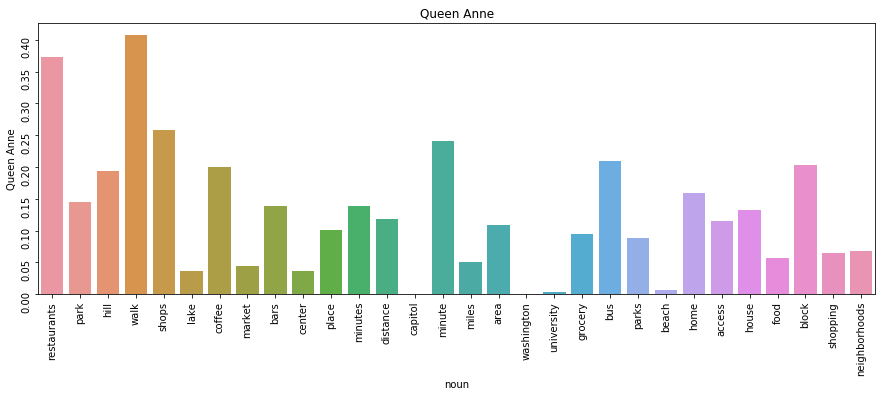

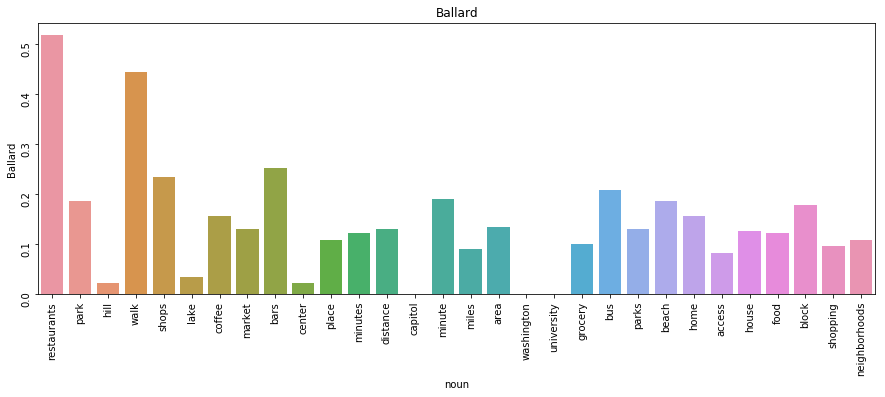

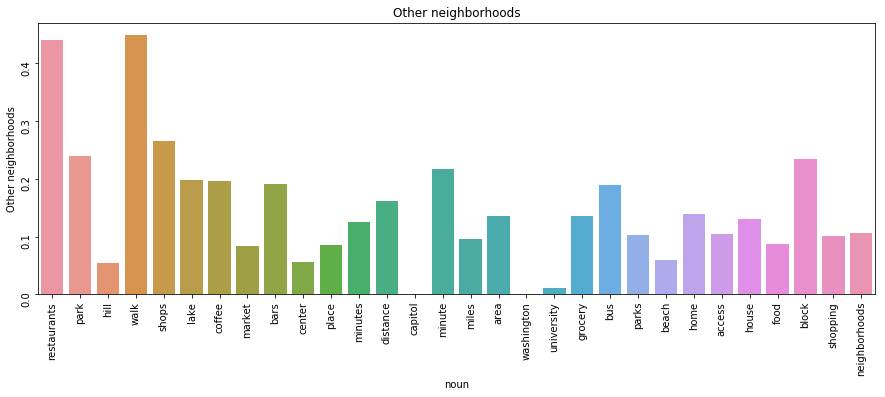

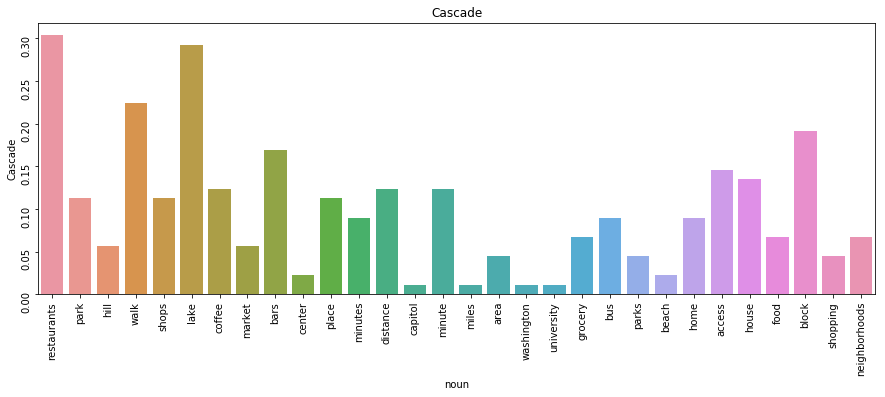

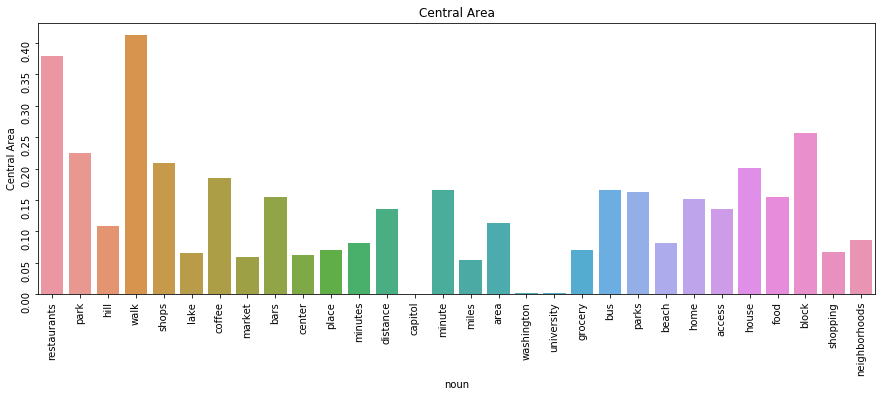

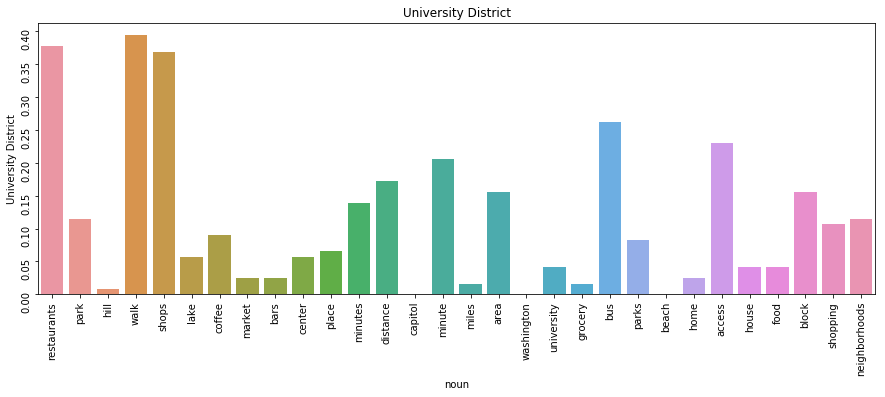

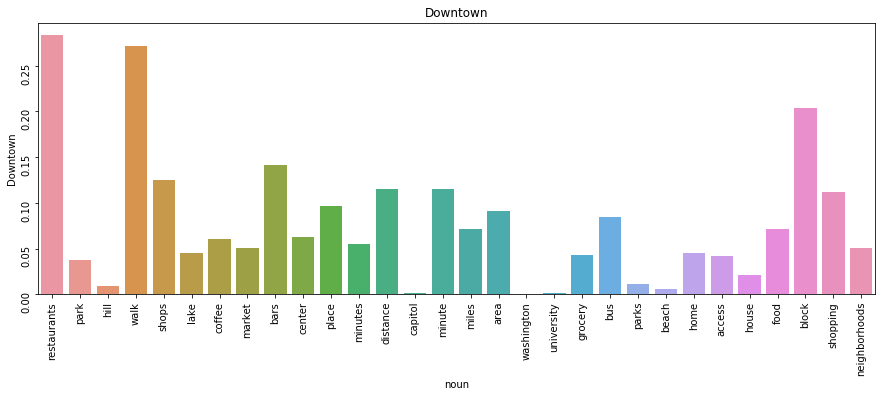

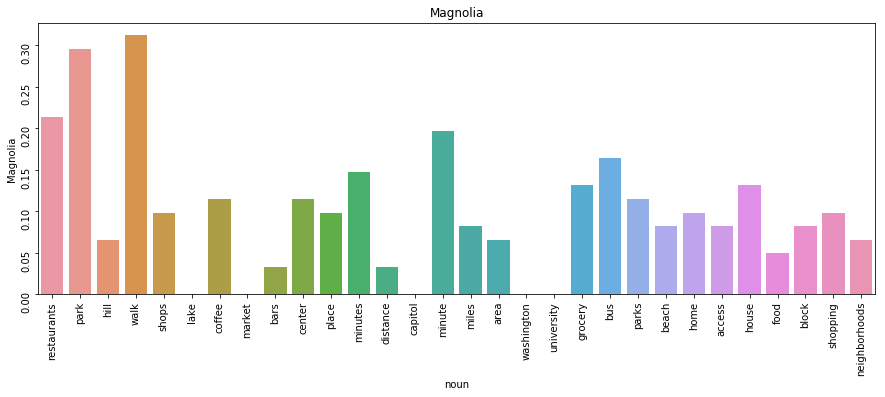

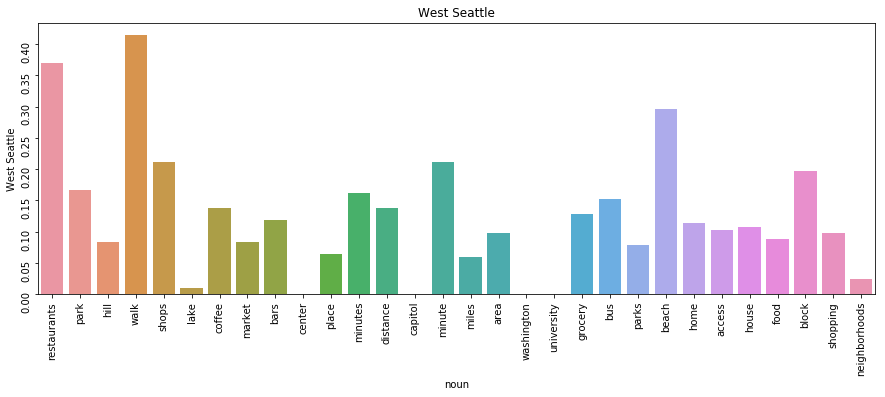

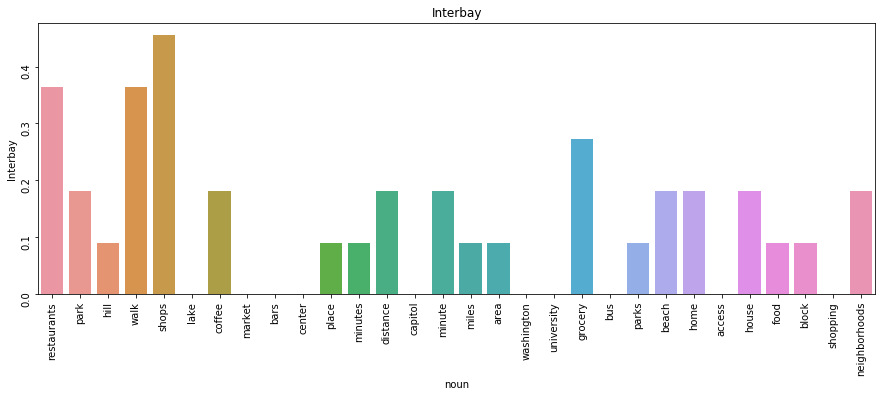

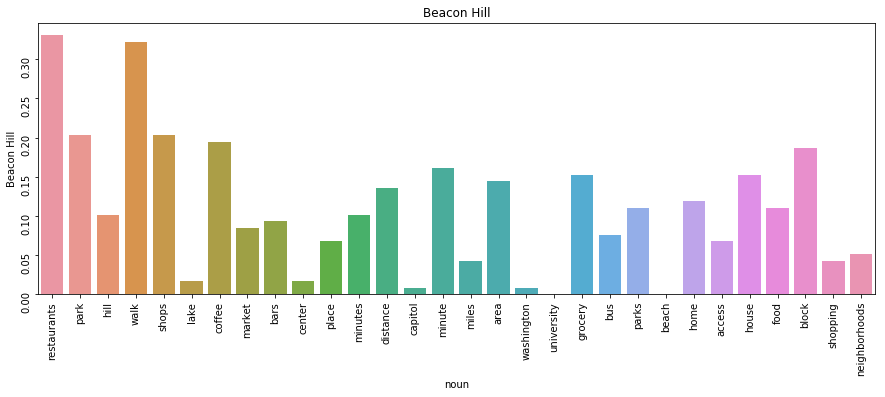

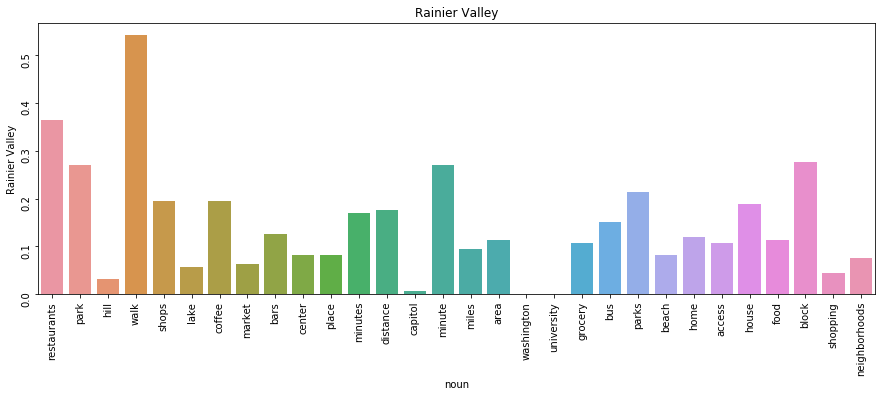

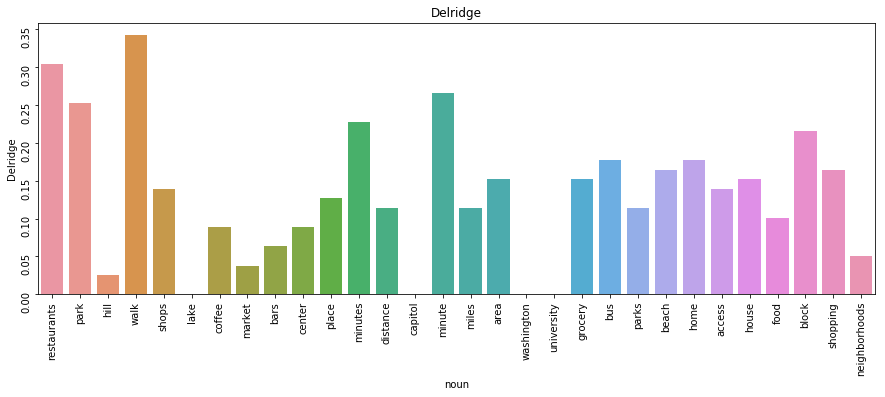

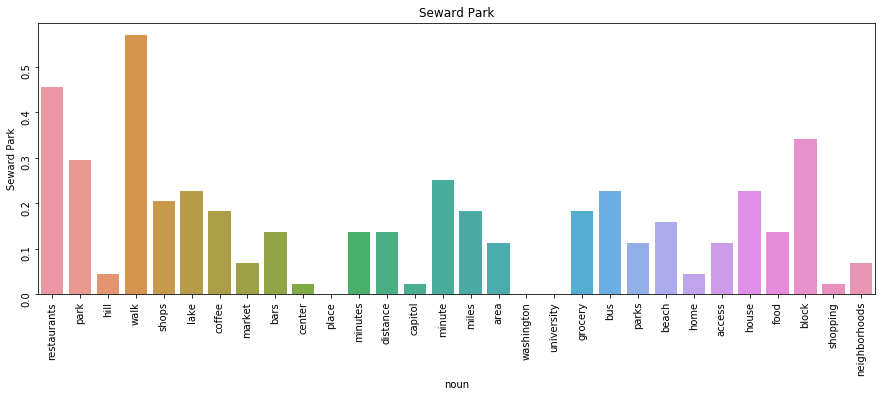

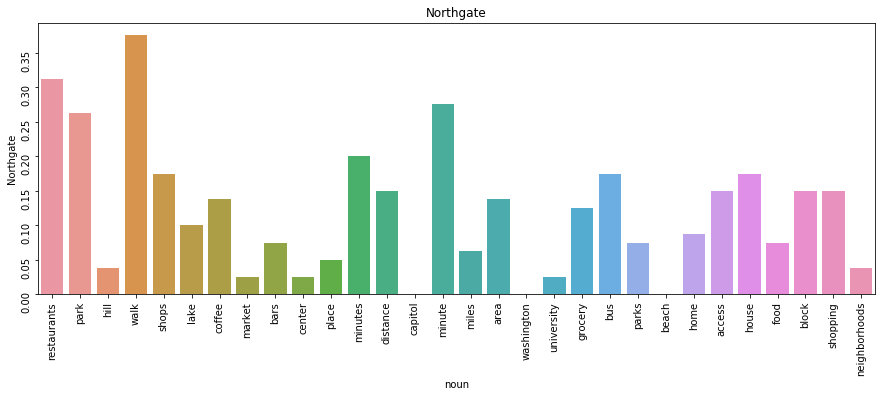

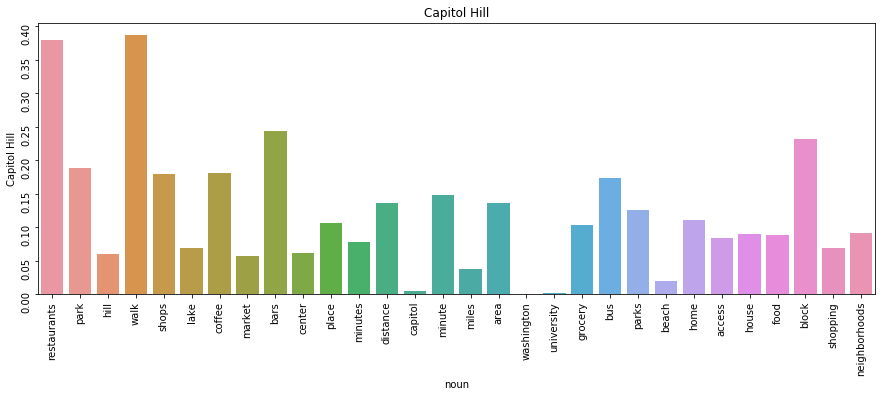

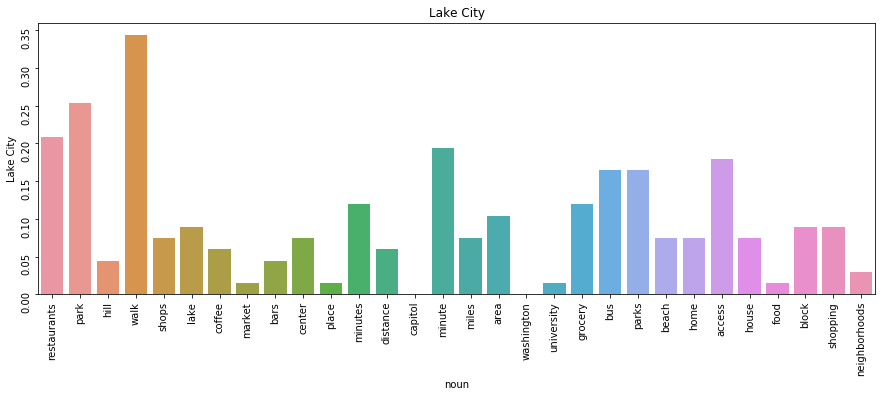

In [79]:
for name in list(listings.neighbourhood_group_cleansed.unique()):
    fig,ax = plt.subplots(1,1,figsize=(15,5))
    sns.barplot(x=location_final['noun'], y=location_final[name])
    ax.tick_params(labelrotation=90)
    plt.title(name)

In [80]:
district_melt = pd.melt(location_final, id_vars=['noun'], value_vars=list(listings.neighbourhood_group_cleansed.unique()))
district_melt.head()

noun    variable     value
0  restaurants  Queen Anne  0.372881
1         park  Queen Anne  0.145763
2         hill  Queen Anne  0.193220
3         walk  Queen Anne  0.406780
4        shops  Queen Anne  0.257627

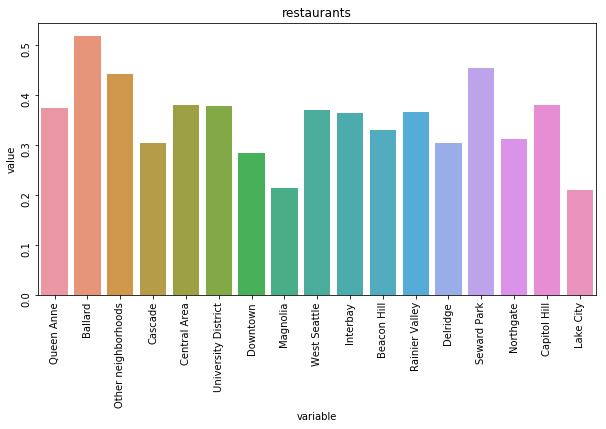

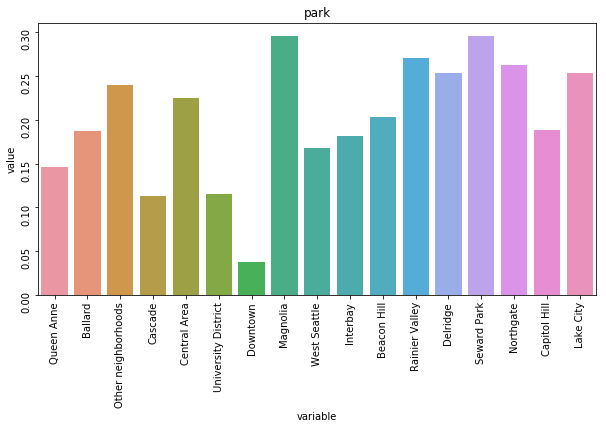

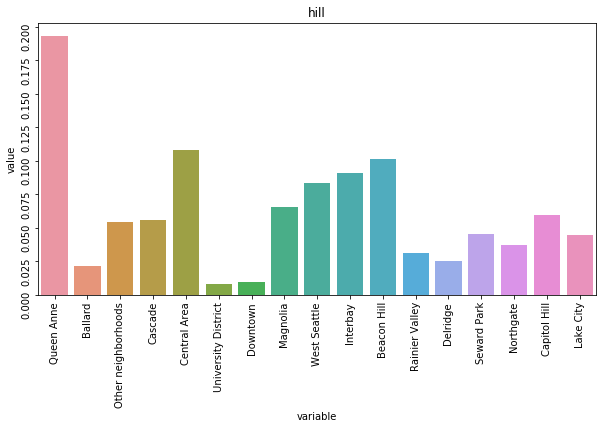

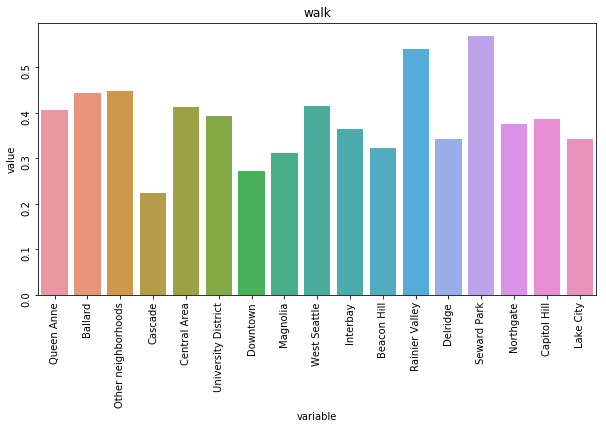

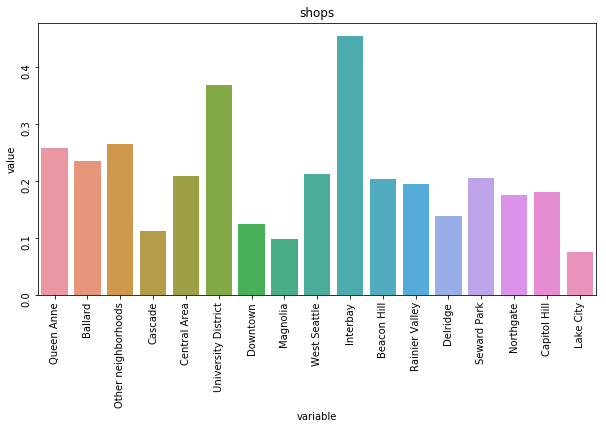

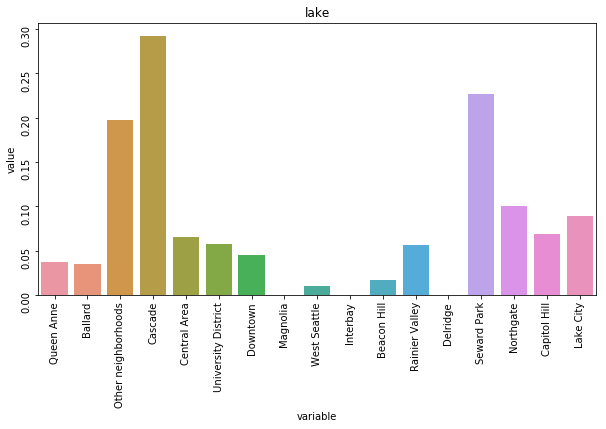

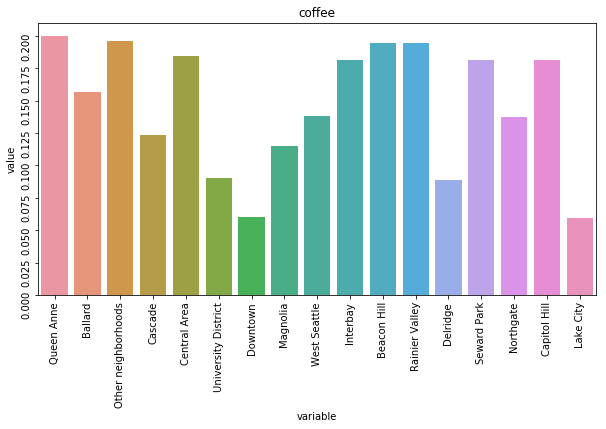

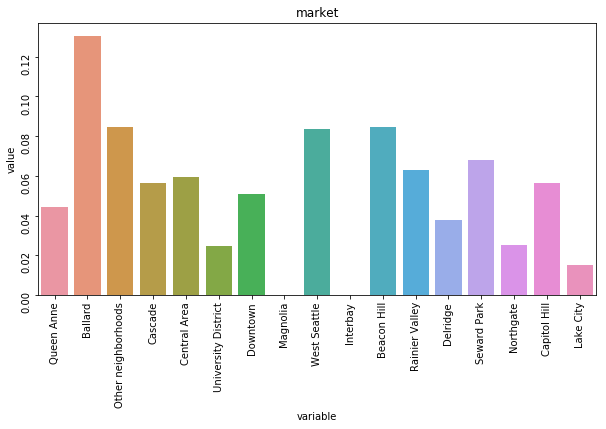

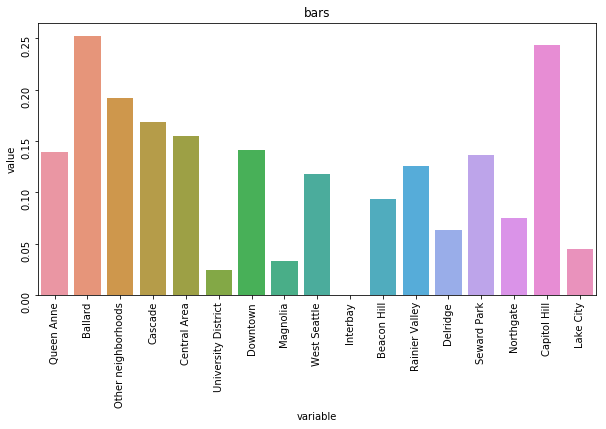

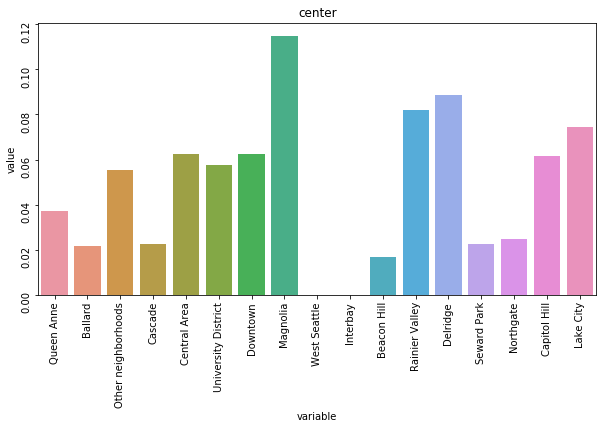

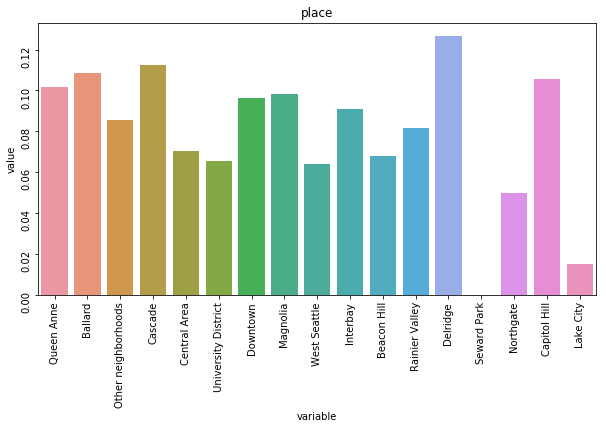

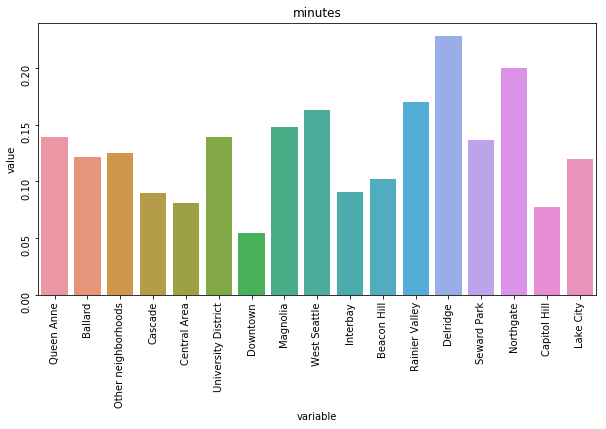

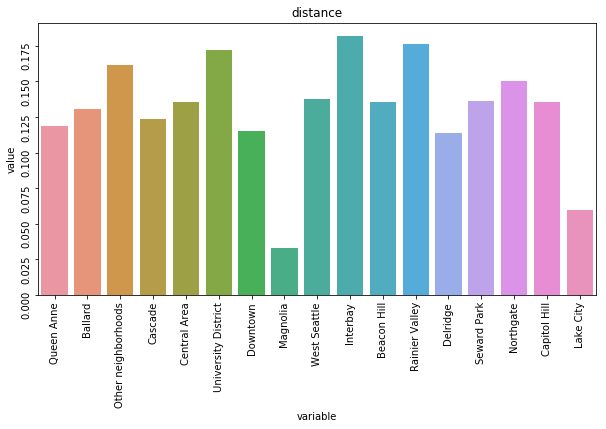

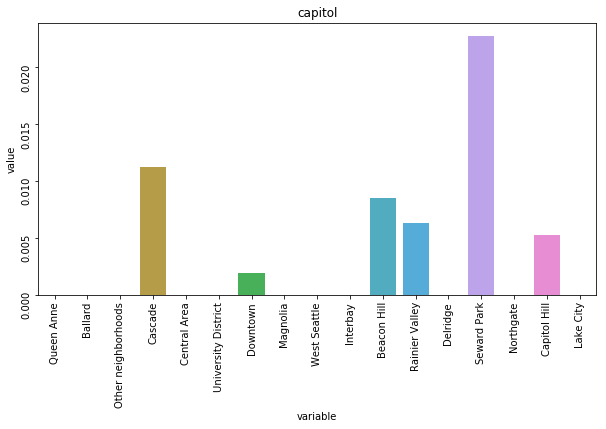

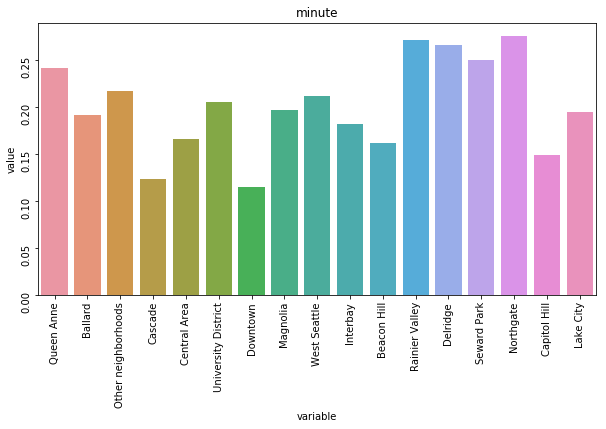

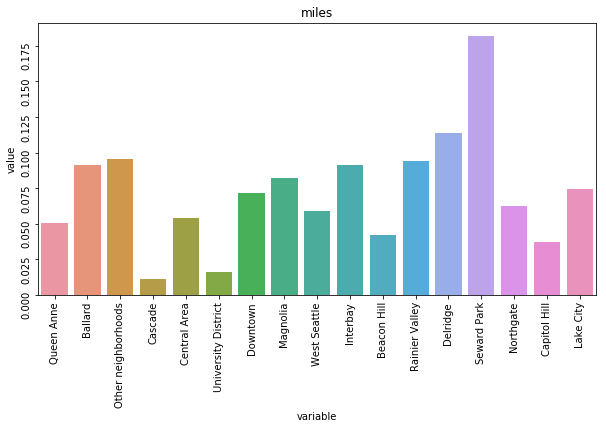

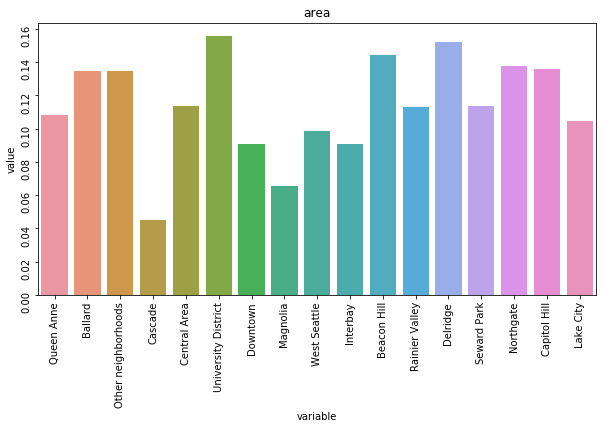

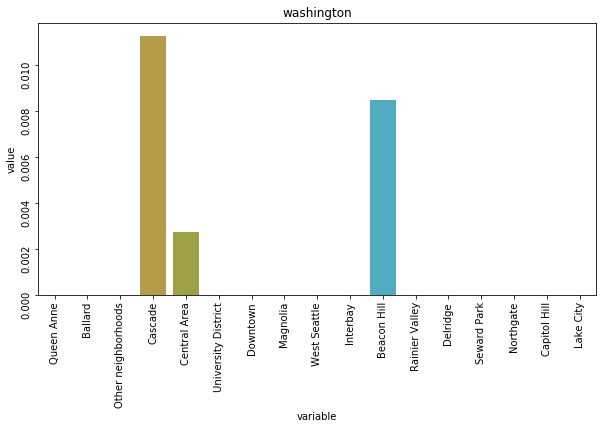

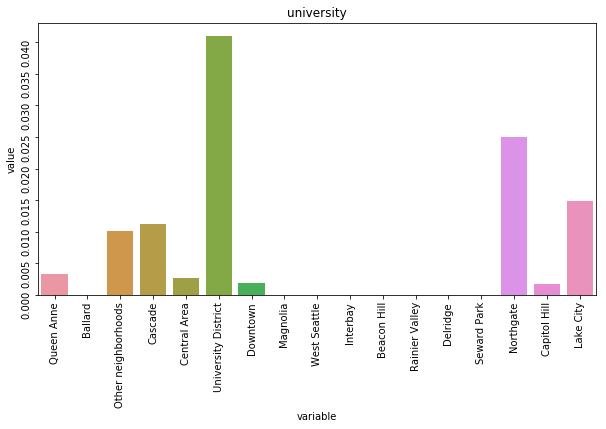

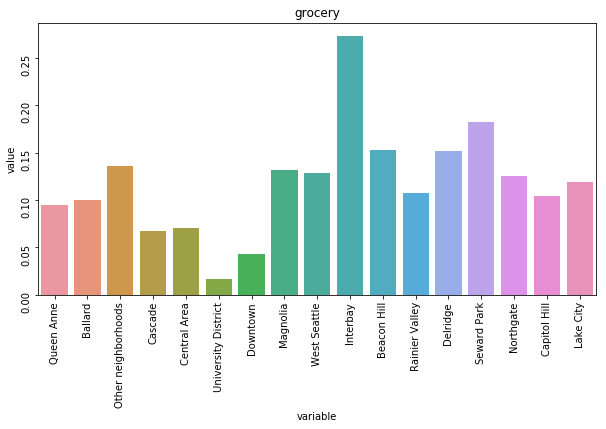

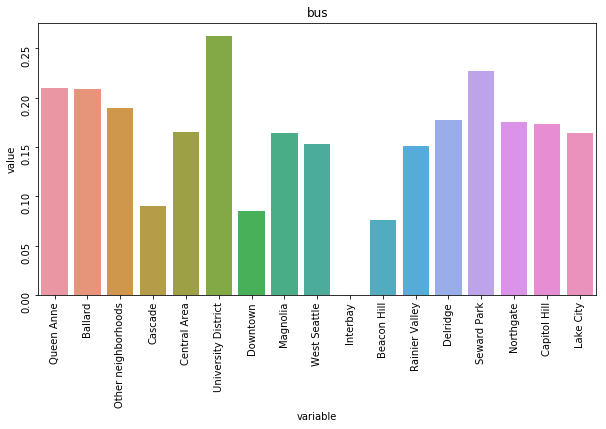

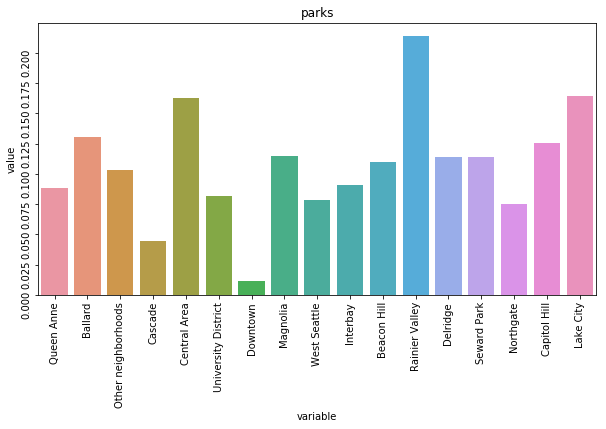

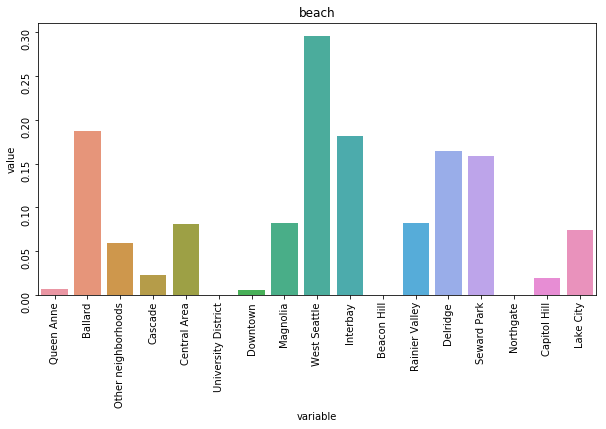

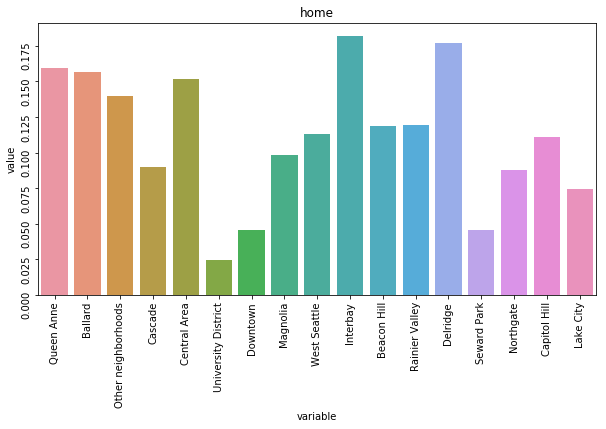

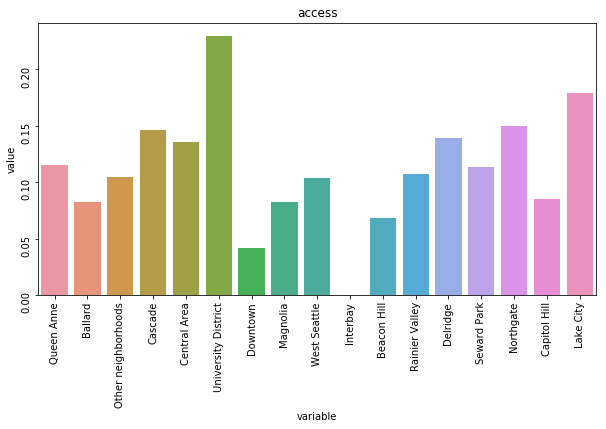

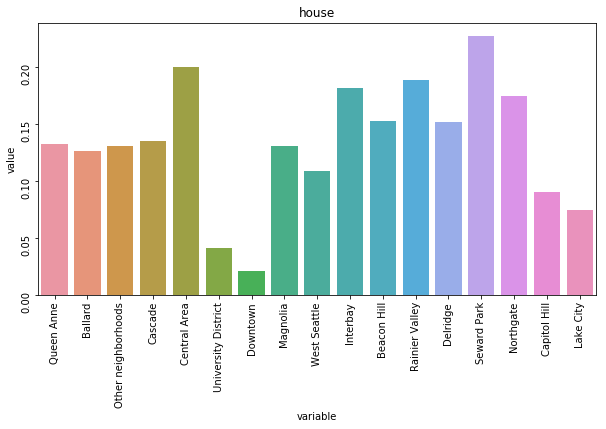

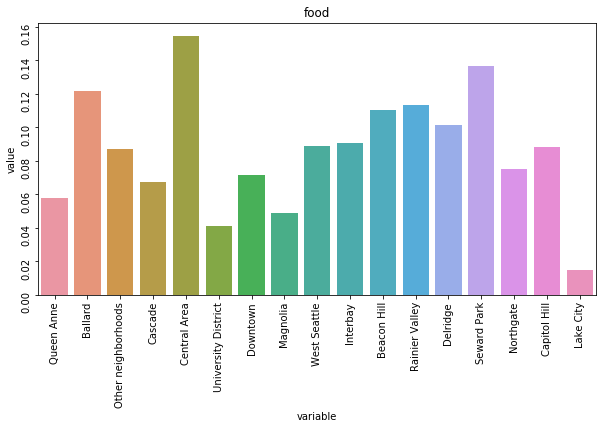

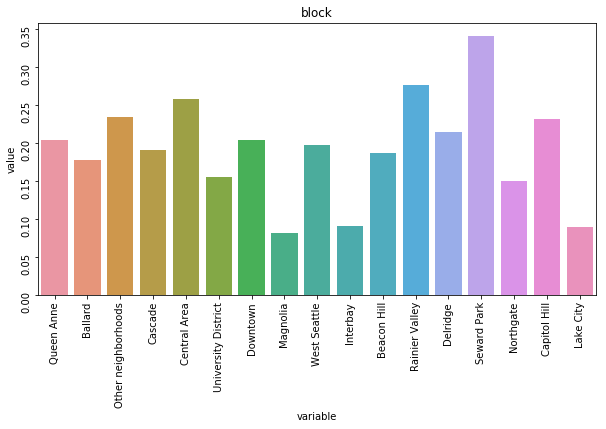

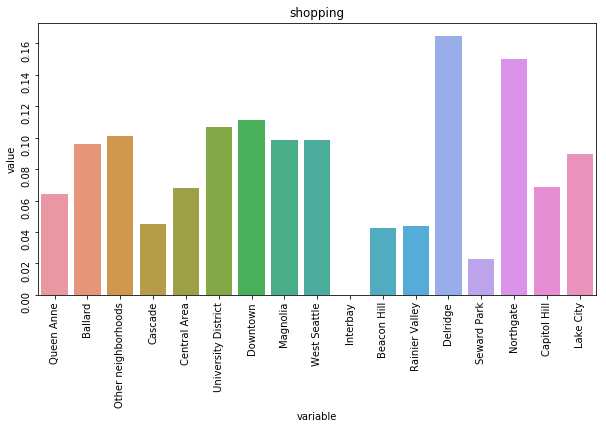

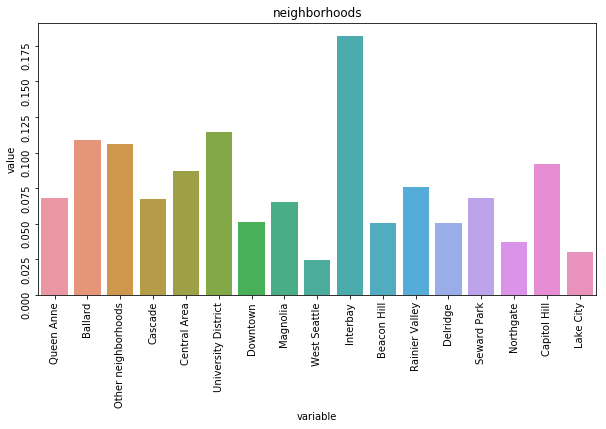

In [81]:
for adj in list(location_final['noun'].unique()):
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    sns.barplot(x=district_melt[district_melt.noun == adj]['variable'], y=district_melt[district_melt['noun'] == adj]['value'])
    ax.tick_params(labelrotation=90)
    plt.title(adj)

# Predict Price

In [82]:
lis.columns[lis.dtypes == "object"]

Index(['host_response_time', 'neighbourhood_group_cleansed', 'property_type',
       'room_type', 'bed_type', 'cancellation_policy'],
      dtype='object')

Check

## Linear regression

In [112]:
def clean_fit_linear_mod(df, response_col, drop_outliers = False, test_size=.3, rand_state=42, lin_model = "Ridge"):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    function creates dummie columns from object columns
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    '''

    X = pd.get_dummies(df, columns = lis.columns[df.dtypes == "object"], drop_first=True , dummy_na=False)
    X = X.drop(columns = response_col)
    Y = df[response_col]    
    if X.isna().any().any():
        print('There are NA values in X!')
        return

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = rand_state)
    
    if drop_outliers:
        Q1 = Y_train.quantile(0.25)
        Q3 = Y_train.quantile(0.75)
        IQR = Q3-Q1
        Lower_Whisker = Q1 - 1.5*IQR
        Upper_Whisker = Q3 + 1.5*IQR
        Y_train = Y_train[Y_train < Upper_Whisker]
        X_train = X_train.loc[Y_train.index]
        
    
    if lin_model == 'Ridge':
        lm = RidgeCV(normalize = True, alphas=[1e-3, 1e-2, 1e-1, 1], store_cv_values = True)
    elif lin_model == 'Lin':
        lm = LinearRegression(normalize = True)
    else:
        print('No regression type provided')
        return
    

        
    lm.fit(X_train, Y_train)
    Y_test_predict = lm.predict(X_test)
    Y_train_predict = lm.predict(X_train)
    
    test_score = r2_score(Y_test, Y_test_predict)
    train_score = r2_score(Y_train, Y_train_predict)
    
    print('Model:', lin_model)
    print('Trained without?', drop_outliers)
    print('train_scrore', round(test_score,2))
    print('test_scrore', round(test_score,2))
    print('\n')
    
    return test_score, train_score, lm, X_train, X_test, Y_train, Y_test



### Try linear regression with some variations

Ridge regression wins

In [113]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(lis, 'price', drop_outliers = False, lin_model = "Lin")#.drop(columns = drop_columns_catboost)
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(lis, 'price', drop_outliers = True, lin_model = "Lin")#.drop(columns = drop_columns_catboost)
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(lis, 'price', drop_outliers = False, lin_model = "Ridge")#.drop(columns = drop_columns_catboost)

Model: Lin
Trained without? False
train_scrore 0.61
test_scrore 0.61


Model: Lin
Trained without? True
train_scrore 0.53
test_scrore 0.53


Model: Ridge
Trained without? False
train_scrore 0.61
test_scrore 0.61




Least important features in terms of linearity factor


coeff_names  coeff_vals
43               aprtmnt_adj_separate    4.504643
44                 aprtmnt_adj_second    4.318770
102               property_type_Other    3.953087
36                   aprtmnt_adj_main    3.634227
68                aprtmnt_adj_natural    3.438295
..                                ...         ...
55                    aprtmnt_adj_big   -4.083721
48                   aprtmnt_adj_easy   -4.162751
20   require_guest_phone_verification   -4.171467
97               property_type_Chalet   -4.670630
26                  aprtmnt_adj_queen   -4.960435

[66 rows x 2 columns]

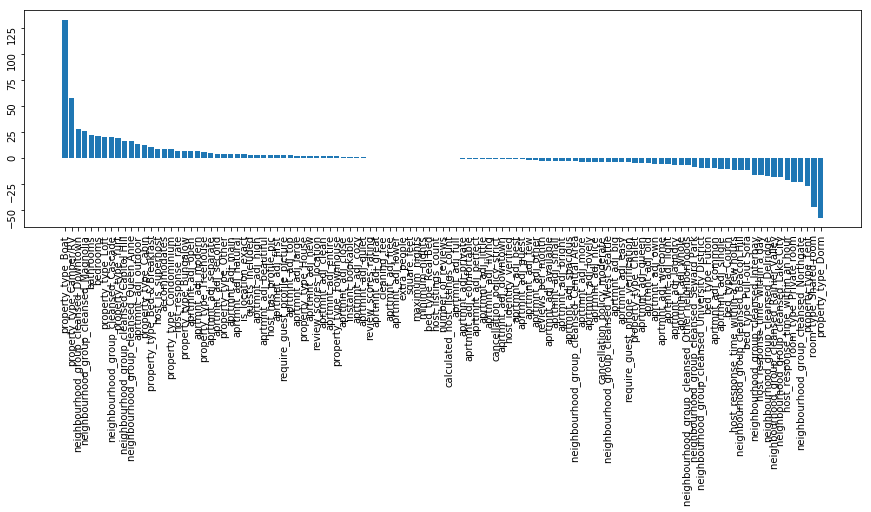

In [115]:
lin_coeff = pd.DataFrame({'coeff_names':X_train.columns, 'coeff_vals':lm_model.coef_}).sort_values(by = 'coeff_vals', ascending = False)
fig, ax = plt.subplots(1,1, figsize = (15,4))
plt.bar(lin_coeff[lin_coeff.coeff_vals != 0].coeff_names, lin_coeff[lin_coeff.coeff_vals != 0].coeff_vals)
ax.tick_params(labelrotation=90);
print('Least important features in terms of linearity factor')
lin_coeff[np.abs(lin_coeff.coeff_vals) < 5]

## Catboost

catboost can handle categorical variables without encoding

In [125]:
def fit_train_catboost(df, response_col, test_size=.3, rand_state=42):
    # initialize data


    cat_col = df.select_dtypes(include = ['object']).columns
    fill_na = [lambda col: col.fillna("unknown")]
    df[cat_col] = df[cat_col].apply(fill_na, axis = 0)


    X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns = ['price']), df['price'], test_size = test_size, random_state=rand_state)


    train_data = X_train
    train_label = Y_train
    test_data = X_test


    # initialize Pool
    train_pool = Pool(train_data, 
                  train_label, 
                  cat_features=train_data.select_dtypes(include = ['object', 'bool']).columns)
    test_pool = Pool(test_data, 
                 cat_features=test_data.select_dtypes(include = ['object', 'bool']).columns) 

    # specify the training parameters 
    model = CatBoostRegressor(iterations=200, 
                          depth=5, 
                          learning_rate=0.6, 
                          loss_function='RMSE',
                             silent=True)
    #train the model
    model.fit(train_pool)
    # make the prediction using the resulting model
    Y_test_predict = model.predict(test_pool)
    Y_train_predict = model.predict(train_pool)
    feature_imp = pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': train_data.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
    
    test_score = r2_score(Y_test, Y_test_predict)
    train_score = r2_score(Y_train, Y_train_predict)
    print('train_scrore', round(test_score,2))
    print('test_scrore', round(test_score,2))
    
    return test_score, train_score, model, X_train, X_test, Y_train, Y_test, feature_imp

def plot_feature_importance(importance, model_type):
    

    
    #Sort the DataFrame in order decreasing feature importance
    importance.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,15))
    #Plot Searborn bar chart
    sns.barplot(x=importance['feature_importance'], y=importance['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [131]:
test_score, train_score, model, X_train, X_test, Y_train, Y_test, feature_imp = fit_train_catboost(lis, 'price')

train_scrore 0.58
test_scrore 0.58


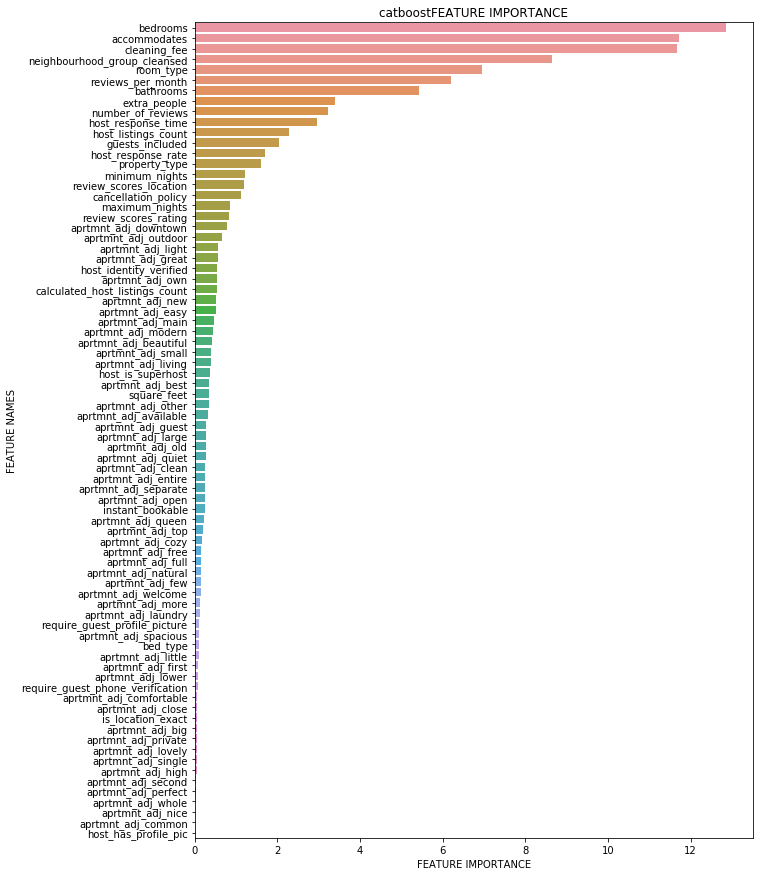

In [126]:
plot_feature_importance(feature_imp[feature_imp.feature_importance >0],'catboost')

In [127]:
list(feature_imp[feature_imp.feature_importance <0.05].feature_names)

['aprtmnt_adj_private',
 'aprtmnt_adj_lovely',
 'aprtmnt_adj_single',
 'aprtmnt_adj_high',
 'aprtmnt_adj_second',
 'aprtmnt_adj_perfect',
 'aprtmnt_adj_whole',
 'aprtmnt_adj_nice',
 'aprtmnt_adj_common',
 'host_has_profile_pic',
 'aprtmnt_adj_bright']

Just some additional insights